# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Проект

# Определение стоимости автомобилей

**Цель проекта:**

Построить модель для определения стоимости подержаных автомобилей.

## Описание проекта

**Импорт библиотек.**

**Подготовка данных**

Данные загружены и обработаны:

* Данные соответствуют описанию.
* Колонки с датами приведены к формату date.
* Пропуски обработаны: заполнены наиболее частым значением по группе параметров, остальное - unknown.
* Удалены полные дубликаты и дубликаты по группе признаков.

Проведен исследовательский анализ данных:

* Выведены описания признаков
* Построены гистограммы распределения
* Построены диаграммы размаха (аномальные значения обработаны)
* Проведены тесты на нормальность распределения признаков
* Построена диаграмма рассеяния
* Проведен корреляционный анализ признаков

Проведена подготовка данных для обучения модели:

* Определены тренировочная, валидационная и тестовые выборки, входные и целевой признаки.
* Построен пайплайн для кодиирования и масштабирования признаков
* Выбрана базовая модель: Линейная регрессия

**Обучение моделей**

Проведено обучение моделей:

* LinearRegression
* DescisionTreeRegression
* С применением RandomizedSearchCV отобрана лучшая линейная модель
* Градиентный бустинг CatBoostRegression
* Градиентный бустинг LGBMRegression

**Анализ моделей**

С учетом важных для заказчика критериев:
* качество предсказания
* время обучения модели
* время предсказания модели

Выбрана оптимальная модель

**Общий вывод**

## Импорт библиотек

In [1]:
!pip install phik -q
#!pip install shap -q
#!pip install optuna -q
#!pip install mlxtend -q
#!pip install imbalanced-learn -q

In [2]:
!pip install --upgrade scikit-learn=='1.4.0' -q # от падучей болезни Юпитера

In [3]:
!pip install lightgbm -q

In [4]:
#import os
import math
import phik
#import shap
#import random
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import plotly.express as px
import statsmodels.api as sm
import matplotlib.colors as colors

In [5]:
from statsmodels.graphics.gofplots import qqplot
from sklearn.feature_selection import f_classif, mutual_info_classif
#from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN
from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import LogisticRegression
#from optuna.integration import OptunaSearchCV
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    #accuracy_score, confusion_matrix, r2_score, precision_score, recall_score, roc_auc_score, f1_score, make_scorer,
    mean_squared_error, mean_absolute_error, root_mean_squared_error)
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
#from sklearn.svm import SVC
from matplotlib import pyplot as plt
#from optuna import distributions, visualization
#from imblearn import under_sampling, over_sampling
from scipy.stats import lognorm, shapiro, normaltest, anderson, uniform, pearsonr
from phik.report import plot_correlation_matrix
#from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
#from sklearn.datasets import make_classification
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, LabelEncoder,
                                   StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, PolynomialFeatures)
#from scipy.spatial.distance import (cosine, euclidean)
from sklearn.model_selection import (train_test_split, KFold, StratifiedKFold, cross_val_score,
                                     GridSearchCV, RandomizedSearchCV)
#from sklearn.utils.class_weight import compute_class_weight
#from sklearn.feature_selection import SelectKBest
#from imblearn.under_sampling import RandomUnderSampler
#from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
#from imblearn.combine import SMOTETomek
from mlxtend.plotting import plot_decision_regions
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
#from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeRegressor
#from itertools import combinations
from sklearn import tree
from phik import phik_matrix
from math import sqrt

In [6]:
from numpy.random import seed
from numpy.random import poisson
from scipy.stats import kstest
from datetime import datetime, date

In [7]:
from catboost import CatBoostClassifier, CatBoostRegressor
from catboost import Pool, cv
from sklearn.model_selection import RepeatedKFold
from lightgbm import LGBMRegressor

In [8]:
import time
import catboost as cb
import lightgbm as lgb

In [9]:
# Зададим отображение всех колонок

pd.set_option("display.max.columns", None)

In [10]:
# Зададим отображение десятичных знаков

pd.options.display.float_format = '{:.3f}'.format

In [11]:
# Определим random_state и test_size

RANDOM_STATE = 45

TEST_SIZE = 0.25

VALID_SIZE = 0.4
TEST_2_SIZE = 0.5

In [12]:
import warnings 
warnings.filterwarnings('ignore')

## Подготовка данных

### Загрузка данных

In [13]:
# Загружаем файлы с нужным разделителем

auto = pd.read_csv(
    'https://code.s3.yandex.net///datasets/autos.csv')

In [14]:
# Сохраним число строк исходного файла

origin = auto.shape[0]

In [15]:
# Создадим элемент для расчета доли оставшихся данных от исходного числа

def rate(df):
    rate = (df.shape[0] / origin)*100
    return rate

In [16]:
# Проверим

rate(auto)

100.0

Выведем первые 5 строк

In [17]:
auto.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Данные в файле соответствуют заявленным.
Названия колонок следует привести к "Змеиному регистру".

In [18]:
# Выведем текущие названия колонок

auto.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [19]:
# Переименуем колонки

auto.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']

In [20]:
# Проверим

auto.head(1)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57


Колонки date_crawled, date_created, last_seen можно привести к типу date

In [21]:
#auto['date_crawled'] = auto['date_crawled'].strftime('%Y-%m-%d')

In [22]:
auto['date_crawled'] = pd.to_datetime(auto['date_crawled']).dt.date
auto['date_created'] = pd.to_datetime(auto['date_created']).dt.date
auto['last_seen'] = pd.to_datetime(auto['last_seen']).dt.date

Посмотрим, какие диапазоны дат у нас в таблице представлены.

In [23]:
for item in (['date_crawled', 'date_created', 'last_seen', 'registration_year', 'registration_month']):
    display(auto[item].value_counts().reset_index().sort_values(by = 'index').T)

,27,29,6,13,10,18,17,2,28,4,15,24,22,30,7,3,5,19,21,26,16,20,25,8,11,14,23,12,9,0,1,31,32,33
index,2016-03-05,2016-03-06,2016-03-07,2016-03-08,2016-03-09,2016-03-10,2016-03-11,2016-03-12,2016-03-13,2016-03-14,2016-03-15,2016-03-16,2016-03-17,2016-03-18,2016-03-19,2016-03-20,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-27,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07
date_crawled,9100,5143,12662,11885,12138,11593,11626,12902,5572,12847,11823,10729,11268,4664,12536,12885,12667,11547,11332,10570,11671,11344,10676,12438,12075,11866,11265,12017,12391,13669,13272,4516,1110,570


,108,89,101,93,94,86,92,95,90,103,98,96,83,81,76,97,104,99,74,66,91,107,77,100,68,75,105,106,71,102,78,85,87,80,88,65,73,70,60,64,58,57,79,49,67,82,56,72,63,84,54,61,69,48,59,47,62,53,55,45,42,51,40,52,50,43,46,44,41,37,38,36,39,35,33,27,29,8,13,10,18,17,3,28,5,15,24,23,30,9,2,4,19,21,25,16,20,26,6,11,14,22,12,7,0,1,31,32,34
index,2014-03-10,2015-03-20,2015-06-18,2015-08-07,2015-08-10,2015-09-04,2015-09-09,2015-11-02,2015-11-08,2015-11-10,2015-11-12,2015-11-17,2015-11-23,2015-11-24,2015-12-05,2015-12-06,2015-12-17,2015-12-27,2015-12-30,2016-01-02,2016-01-03,2016-01-06,2016-01-07,2016-01-08,2016-01-10,2016-01-13,2016-01-15,2016-01-16,2016-01-17,2016-01-18,2016-01-19,2016-01-20,2016-01-22,2016-01-23,2016-01-24,2016-01-25,2016-01-26,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,2016-02-11,2016-02-12,2016-02-13,2016-02-14,2016-02-15,2016-02-16,2016-02-17,2016-02-18,2016-02-19,2016-02-20,2016-02-21,2016-02-22,2016-02-23,2016-02-24,2016-02-25,2016-02-26,2016-02-27,2016-02-28,2016-02-29,2016-03-01,2016-03-02,2016-03-03,2016-03-04,2016-03-05,2016-03-06,2016-03-07,2016-03-08,2016-03-09,2016-03-10,2016-03-11,2016-03-12,2016-03-13,2016-03-14,2016-03-15,2016-03-16,2016-03-17,2016-03-18,2016-03-19,2016-03-20,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-27,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07
date_created,1,1,1,1,1,2,1,1,1,1,1,1,2,2,3,1,1,1,3,4,1,1,3,1,4,3,1,1,3,1,3,2,2,3,2,4,3,4,6,5,6,7,3,13,4,2,7,3,6,2,9,6,4,14,6,14,6,9,8,21,22,12,23,11,12,22,20,21,22,49,46,50,37,396,601,8186,5505,12244,11854,12153,11546,11647,12840,6016,12478,11804,10803,11119,4990,12197,12918,12691,11451,11312,10591,11692,11386,10578,12475,12088,11820,11289,11963,12362,13719,13317,4104,1105,549


,33,32,31,29,27,26,24,10,28,25,20,22,3,30,21,15,14,13,18,16,17,23,19,12,11,9,7,8,6,5,4,2,0,1
index,2016-03-05,2016-03-06,2016-03-07,2016-03-08,2016-03-09,2016-03-10,2016-03-11,2016-03-12,2016-03-13,2016-03-14,2016-03-15,2016-03-16,2016-03-17,2016-03-18,2016-03-19,2016-03-20,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-27,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07
last_seen,470,1518,1912,2936,3638,4197,4728,8538,3090,4433,5929,5919,10399,2501,5922,7189,7295,7407,6542,6969,6919,5829,6126,8072,8401,8571,8705,8623,8968,9104,9172,43901,75616,44830


,60,111,125,88,147,84,115,114,100,133,79,97,128,142,80,53,135,136,137,103,139,140,104,76,90,141,87,92,96,85,93,73,75,107,108,95,81,106,83,144,105,91,145,66,71,74,69,72,68,62,70,65,61,43,59,58,57,56,55,51,54,52,50,37,48,42,46,47,49,44,45,39,40,33,41,38,35,36,31,34,32,30,28,25,26,24,23,20,17,13,11,8,1,0,3,7,5,6,2,4,9,10,12,14,16,19,21,27,29,18,15,22,64,126,143,102,150,82,101,130,77,138,118,132,113,89,146,110,119,67,148,109,116,124,99,78,131,86,120,129,134,98,123,117,127,149,94,122,112,121,63
index,1000,1001,1039,1111,1200,1234,1253,1255,1300,1400,1500,1600,1602,1688,1800,1910,1915,1919,1920,1923,1925,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2066,2200,2222,2290,2500,2800,2900,3000,3200,3500,3700,3800,4000,4100,4500,4800,5000,5300,5555,5600,5900,5911,6000,6500,7000,7100,7500,7800,8000,8200,8455,8500,8888,9000,9229,9450,9996,9999
registration_year,37,1,1,3,1,4,1,1,2,1,5,2,1,1,5,101,1,1,1,2,1,1,2,7,3,1,3,3,3,4,3,11,8,2,2,3,4,2,4,1,2,3,1,18,12,9,14,11,15,27,13,25,32,188,41,46,57,64,82,113,99,108,118,333,167,213,173,169,143,175,173,285,283,588,263,316,430,399,756,538,667,942,1318,2806,2762,3002,3438,4841,9607,10835,14666,17899,22728,24490,20124,19092,19763,19611,22109,19900,17183,15391,14503,10764,9909,7178,4131,2537,1302,9599,10441,3959,25,1,1,2,1,4,2,1,7,1,1,1,1,3,1,2,1,17,1,2,1,1,2,5,1,4,1,1,1,2,1,1,1,1,3,1,1,1,26


,0,10,12,1,3,4,2,5,11,9,6,8,7
index,0,1,2,3,4,5,6,7,8,9,10,11,12
registration_month,37352,23219,21267,34373,29270,29153,31508,27213,22627,23813,26099,24186,24289


In [24]:
# Выведем описание колонок с датами

auto[['date_crawled', 'date_created', 'last_seen']].describe()

,date_crawled,date_created,last_seen
count,354369,354369,354369
unique,34,109,34
top,2016-04-03,2016-04-03,2016-04-06
freq,13669,13719,75616


Получается довольно занятная картина. 

Выгрузка объявлений происходила в марте - апреле 2016г., ок. 

Дата последней активности пользователся ровно такая же , как и даты выгрузки объявлений.

Дата подачи объявлений с марта 2014 по апрель 2016г. При этом основная масса объявлений создана в марте - апреле 2016г.

Но при этом дата регистрации автомобиля доходит до 2018г(значимые цифры) и 2019 (незначительное число). Число объявлений снижается с 2005 года до 2015, потом 2016-2017гг некоторый всплеск активности и 2018 резкое снижение.
Максимальное число объявлений в 2000г.

(По этому поводу я испытываю некоторый когнитивный диссонанс. Хотя, если принять во внимание, как была написана теория к этому спринту, то удивляться не приходится. Могу предположить, что исходные данные были от 2016, потом пару лет добавили, а даты выгрузки рандомно раскидали из исходного файла)

Выведем описание числовых данных.

In [25]:
auto.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000
mean,4416.657,2004.234,110.094,128211.173,5.715,0.000,50508.689
std,4514.159,90.228,189.850,37905.342,3.726,0.000,25783.096
min,0.000,1000.000,0.000,5000.000,0.000,0.000,1067.000
25%,1050.000,1999.000,69.000,125000.000,3.000,0.000,30165.000
50%,2700.000,2003.000,105.000,150000.000,6.000,0.000,49413.000
75%,6400.000,2008.000,143.000,150000.000,9.000,0.000,71083.000
max,20000.000,9999.000,20000.000,150000.000,12.000,0.000,99998.000


В числовых колонках все данные заполнены (нет пропусков). (Следует обратить внимание, что число фото везде = 0). 
В данных, очевидно, есть аномальные значения, такие как год регистрации = 1000 или 9999; цена и мощность = 0. К этому мы вернемся чуть позже.

В целом, распределение данных по квартилям выглядят довольно равномерно: цена 1050 - 2700 - 6400; год регистрации 1999 - 2003 - 2008; мощность 69 - 105 - 143; месяц регистрации 3 - 6 - 9.

Колонки с количеством фото и почтовым кодом, думаю, не должны влиять на параметры продаж автомобилей. Почтовый код, вероятно, определяет район города. Но применительно к автомобилям, это не ключевой параметр (не как у недвижимости). 

Собственно говоря, последняя активность пользователя, вероятно, тоже не важна.

In [26]:
# Число автомобилей с датой регистрации выше 2016 года:

auto[auto['registration_year']>2016]['price'].count()

14530

In [27]:
# Доля от исходных данных:

(auto[auto['registration_year']>2016]['price'].count()/origin)*100

4.100245788993958

(Ну и что вот с этим делать? Когда время подачи объявления важно, велико (2 года, включающие значимые события в мире), но при этом есть 14 тыс строк с 2017 по 2019гг... вернемся к этому вопросу позже)

Посмотрим, как визуально выглядят даты

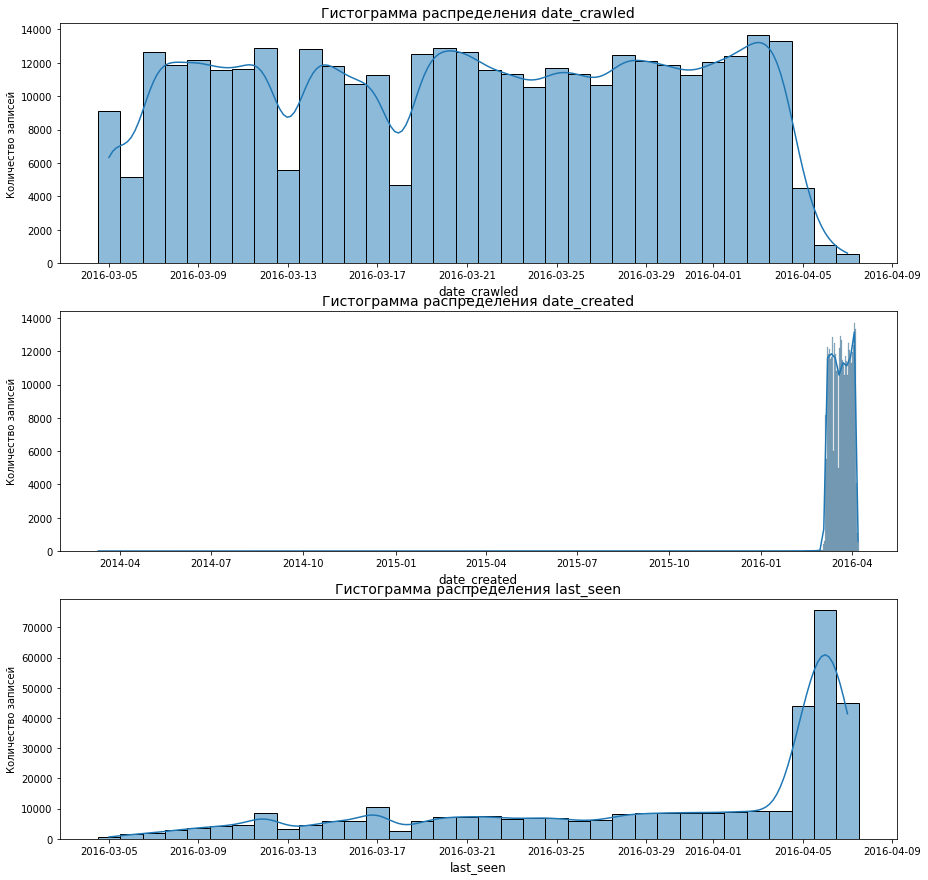

In [28]:
# Визуализируем распределение признаков

features = ['date_crawled', 'date_created', 'last_seen']

fig, axes = plt.subplots(len(features),1, figsize=(15,15))

for i, item in enumerate(features):
       
    sns.histplot(x=auto[item], ax=axes[i], kde=True, bins='auto');
    
    axes[i].set_title(f'Гистограмма распределения {item}', fontsize=14)
    axes[i].set_xlabel(item, fontsize=12)
    axes[i].set_ylabel('Количество записей')
    
    fig.show()

Это очень. Очень странные даты.

Если они все относятся к марту-апрелю 2016 г., то это не информация, а какой-то мусор.

Вот сейчас все больше склоняюсь к тому, чтобы удалить даты выгрузки объявления, активность пользователя, дату регистрации объявления (да, и ее тоже). А также число картинок и почтовый код (по коду, кстати, получаются разные земли и города Германии, так что вопросики к этому датасету все приростают).

In [29]:
auto['postal_code'].value_counts().to_frame()

,postal_code
10115,819
65428,613
66333,343
32257,317
44145,317
...,...
21782,1
9517,1
29367,1
38325,1


Это чисто из любопытства - проверила рандомно почтовые коды (потому что очень уж не типично распределение марок машин для средне-русских пространств) - и это-таки Германия!

Выведем информацию о файле

In [30]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Есть пропуски в нескольких колонках. Посчитаем число пропусков.

In [31]:
auto.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [32]:
# Пропуски визуально

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns={0:'space'})
            .query('space > 0')
            .sort_values(by='space', ascending = True)
            .plot(kind='barh', figsize=(15,3), rot=0, legend=False, fontsize=12, color='SteelBlue', edgecolor='black', grid=True)
            .set_title('Доля пропущенных данных, %' + "\n", fontsize = 14)    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

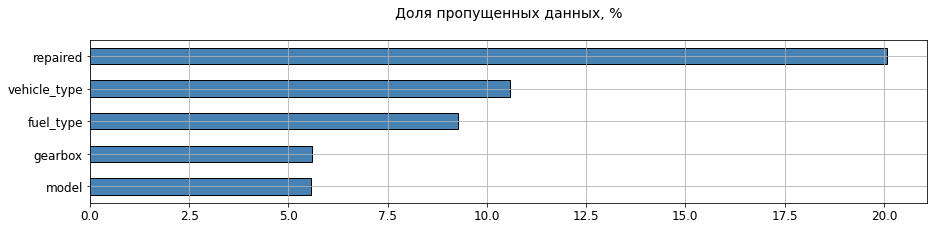

In [33]:
pass_value_barh(auto)

Пропуски составляют от 5 до 10 % данных в колонках тип кузова, коробка передач, модель, тип топлива, и ~ 20% в колонке ремонт.

In [34]:
auto[(auto['registration_year'] > 1800) & (auto['registration_year'] < 2200)].sort_values(by = 'registration_year')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
155833,2016-03-11,15,NaN,1910,NaN,0,NaN,5000,0,NaN,trabant,NaN,2016-03-11,0,90491,2016-03-25
154571,2016-03-24,0,NaN,1910,NaN,0,NaN,5000,0,NaN,jeep,NaN,2016-03-24,0,24622,2016-03-27
154559,2016-04-03,0,small,1910,manual,0,colt,150000,0,petrol,mitsubishi,NaN,2016-04-03,0,46397,2016-04-07
303721,2016-03-27,0,NaN,1910,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-03-27,0,1157,2016-04-07
40133,2016-03-23,0,NaN,1910,NaN,0,other,5000,0,NaN,volkswagen,NaN,2016-03-23,0,85045,2016-03-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35506,2016-03-31,1200,NaN,2019,manual,140,156,150000,5,petrol,alfa_romeo,no,2016-03-31,0,91058,2016-04-06
62996,2016-03-27,7900,NaN,2019,auto,170,passat,150000,12,NaN,volkswagen,no,2016-03-27,0,42103,2016-04-01
74469,2016-04-01,4800,NaN,2019,manual,160,mondeo,150000,0,petrol,ford,NaN,2016-04-01,0,85235,2016-04-03
247100,2016-03-22,0,NaN,2019,manual,0,twingo,150000,2,petrol,renault,yes,2016-03-22,0,63589,2016-03-28


Автоматическая коробка передач была запатентована в 1935 году. Следовательно, все, что раньше - это ручная коробка передач (за исключением аномальных 1000 года регистрации и т.п.)

In [35]:
# И число таких автомобилей в таблице:

auto[(auto['registration_year'] > 1900) & (auto['registration_year'] < 1935)]['registration_year'].isna().sum()

0

In [36]:
# Заменим Nan на manual

for year in auto['registration_year'].unique():
    auto.loc[(auto['registration_year'] >1900)&(auto['registration_year'] <1935)&(auto['gearbox'].isna()), 'gearbox'] = 'manual'

In [37]:
# Проверим

auto[(auto['registration_year'] > 1900) & (auto['registration_year'] < 1935)]['registration_year'].isna().sum()

0

В результате всех манипуляций, решила заполнить пропуски таким образом:
* Модель, коробка передач, тип кузова, тип топлива: сначала на наиболее частое значение по группе признаков (год выпуска, бренд, модель).
* Оставшиеся в этих колонках пропуски - на unknown
* Пропуски в колонке ремонт - на unknown, потому что здесь нет никаких вариантов найти истину.

Итак сначала модель: по году выпуска, бренду и почтовому коду.

In [38]:
auto['model'] = auto.groupby(['registration_year', 'brand', 'postal_code'])['model'].transform(
    lambda x: x.fillna((x.mode()[0] if x.count()!=0 else np.nan))
)

In [39]:
# Осталось пропусков:

auto.model.isna().sum()

13845

Модель по по году выпуска и бренду 

In [40]:
auto['model'] = auto.groupby(['registration_year', 'brand'])['model'].transform(
    lambda x: x.fillna((x.mode()[0] if x.count()!=0 else np.nan))
)

In [41]:
# Осталось пропусков:

auto.model.isna().sum()

3442

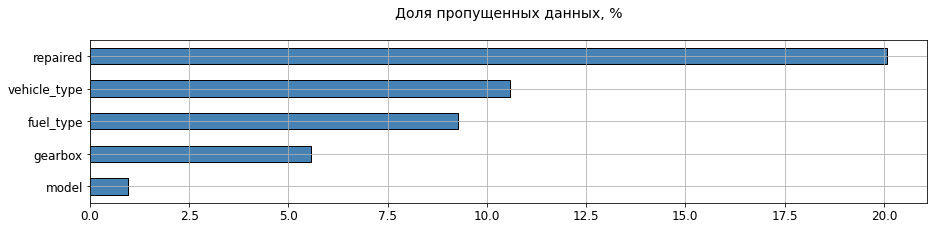

In [42]:
pass_value_barh(auto)

Около 1 процента неизвестных значений.

In [43]:
auto.model = auto.model.replace({np.nan: 'unknown'})

Коробка передач по году выпуска, бренду и модели

In [44]:
auto['gearbox'] = auto.groupby(['registration_year', 'brand', 'model'])['gearbox'].transform(
    lambda x: x.fillna((x.mode()[0] if x.count()!=0 else np.nan))
)

In [45]:
# Осталось пропусков:

auto.gearbox.isna().sum()

363

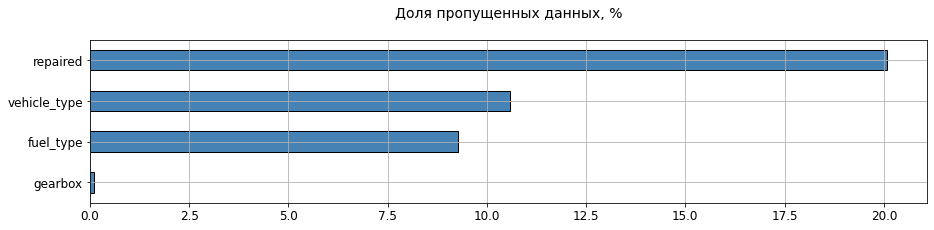

In [46]:
pass_value_barh(auto)

С коробкой передач совсем ничтожное число пропусков осталось

In [47]:
auto.gearbox = auto.gearbox.replace({np.nan: 'unknown'})

Тип кузова по году выпуска, бренду и модели

In [48]:
auto['vehicle_type'] = auto.groupby(['registration_year', 'brand', 'model'])['vehicle_type'].transform(
    lambda x: x.fillna((x.mode()[0] if x.count()!=0 else np.nan))
)

In [49]:
# Осталось пропусков:

auto.vehicle_type.isna().sum()

14721

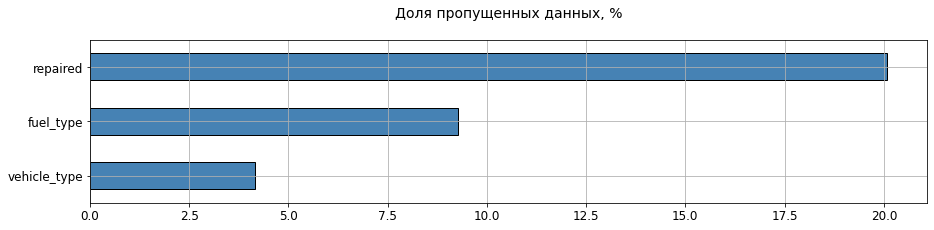

In [50]:
pass_value_barh(auto)

Тип кузова уже сложнее подобрать: они очень разные, но тем не менее пропусков осталось около 4%

In [51]:
auto.vehicle_type = auto.vehicle_type.replace({np.nan: 'unknown'})

Тип топлива по году выпуска, бренду и модели

In [52]:
auto['fuel_type'] = auto.groupby(['registration_year', 'brand', 'model'])['fuel_type'].transform(
    lambda x: x.fillna((x.mode()[0] if x.count()!=0 else np.nan))
)

In [53]:
# Осталось пропусков:

auto.fuel_type.isna().sum()

464

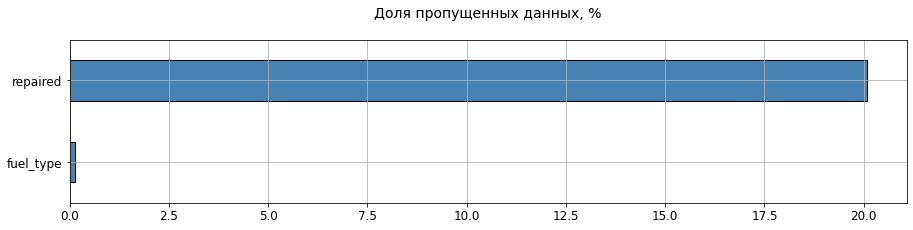

In [54]:
pass_value_barh(auto)

По типу топлива довольно хорошо заполнилось все, пропусков практически нет.

In [55]:
auto.fuel_type = auto.fuel_type.replace({np.nan: 'unknown'})

И ремонты придется все 20 % менять на unknown

In [56]:
# Замена пропусков на unknown в колонке ремонты

auto.repaired = auto.repaired.replace({np.nan: 'unknown'})

In [57]:
auto.repaired.unique()

array(['unknown', 'yes', 'no'], dtype=object)

Проверим, сколько записей имеют аномальный год регистрации

In [58]:
auto[(auto['registration_year'] < 1900) | (auto['registration_year'] > 2016)]['registration_year'].count()

14596

Домустим, что годы выше 2016 - это ошибка. хоть их и довольно много.

Данных немного, полагаю, можно их удалить.

In [59]:
auto = auto[(auto['registration_year'] >= 1900) & (auto['registration_year'] <= 2016)]

In [60]:
# Проверим

auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339773 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        339773 non-null  object
 1   price               339773 non-null  int64 
 2   vehicle_type        339773 non-null  object
 3   registration_year   339773 non-null  int64 
 4   gearbox             339773 non-null  object
 5   power               339773 non-null  int64 
 6   model               339773 non-null  object
 7   kilometer           339773 non-null  int64 
 8   registration_month  339773 non-null  int64 
 9   fuel_type           339773 non-null  object
 10  brand               339773 non-null  object
 11  repaired            339773 non-null  object
 12  date_created        339773 non-null  object
 13  number_of_pictures  339773 non-null  int64 
 14  postal_code         339773 non-null  int64 
 15  last_seen           339773 non-null  object
dtypes:

In [61]:
auto['registration_year'].value_counts().reset_index().sort_values(by = 'index').T

,51,94,93,92,81,91,90,82,70,76,87,74,75,80,72,78,67,69,85,86,77,71,83,73,88,84,79,89,61,65,68,63,66,62,59,64,60,58,41,57,56,55,54,53,49,52,50,48,35,46,40,44,45,47,42,43,37,38,31,39,36,33,34,29,32,30,28,26,23,24,22,21,19,16,13,11,8,1,0,3,7,5,6,2,4,9,10,12,14,15,18,20,25,27,17
index,1910,1915,1919,1920,1923,1925,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
registration_year,101,1,1,1,2,1,1,2,7,3,1,3,3,3,4,3,11,8,2,2,3,4,2,4,1,2,3,1,18,12,9,14,11,15,27,13,25,32,188,41,46,57,64,82,113,99,108,118,333,167,213,173,169,143,175,173,285,283,588,263,316,430,399,756,538,667,942,1318,2806,2762,3002,3438,4841,9607,10835,14666,17899,22728,24490,20124,19092,19763,19611,22109,19900,17183,15391,14503,10764,9909,7178,4131,2537,1302,9599


In [62]:
# Проверим значения в текстовых колонках

columns = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']
for col in columns:
    print(col, '\n', auto[col].value_counts().to_frame(), '\n')

vehicle_type 
              vehicle_type
sedan               98436
small               86006
wagon               67072
bus                 30281
convertible         20686
coupe               17303
suv                 12491
other                3909
unknown              3589 

gearbox 
          gearbox
manual    273046
auto       66493
unknown      234 

fuel_type 
           fuel_type
petrol       233102
gasoline     100115
lpg            5185
cng             545
unknown         289
hybrid          229
other           219
electric         89 

brand 
                 brand
volkswagen      73187
opel            38000
bmw             35800
mercedes_benz   31004
audi            28478
ford            24170
renault         16928
peugeot         10624
fiat             9159
seat             6535
mazda            5397
skoda            5358
smart            5029
citroen          4916
nissan           4747
toyota           4460
hyundai          3448
sonstige_autos   3197
volvo            3142
m

В колонке Brand есть значение на немецком sonstige_autos, но в принципе, оно уникально и включает прочие марки. Думаю, можно его не переименовывать.

In [63]:
# Модель рассмотрим по уникальным значениям

auto['model'].unique()

array(['golf', 'a4', 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'civic', 'transporter', 'punto',
       'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one', 'fortwo',
       '1er', 'b_klasse', 'signum', 'astra', 'unknown', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'meriva', 'z_reihe', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'caddy', 'mondeo', 'cordoba', 'colt', 'impreza', 'vectra',
       'berlingo', 'tiguan', 'sharan', '6_reihe', 'c4', 'panda', 'up',
       'i_reihe', 'ceed', '5_reihe', 'yeti', 'octavia', 'zafira', 'mii',
       'rx_reihe', '1_reihe', '6er', 'modus', 'fox', 'matiz', 'beetl

Здесь нет повторов или не корретных значений (проверила в EXCEL).

Проверим полные дубликаты.

In [64]:
auto[auto.duplicated(keep='first')]['price'].count()

6941

In [65]:
auto[auto.duplicated(keep=False)].sort_values(by=['date_crawled', 'registration_year']).head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
205645,2016-03-05,1500,coupe,1970,auto,90,other,100000,3,petrol,opel,unknown,2016-03-05,0,65207,2016-03-09
286627,2016-03-05,1500,coupe,1970,auto,90,other,100000,3,petrol,opel,unknown,2016-03-05,0,65207,2016-03-09
316654,2016-03-05,1500,coupe,1970,auto,90,other,100000,3,petrol,opel,unknown,2016-03-05,0,65207,2016-03-09
81577,2016-03-05,7800,sedan,1984,manual,44,kaefer,5000,10,petrol,volkswagen,no,2016-03-05,0,45470,2016-03-17
290968,2016-03-05,7800,sedan,1984,manual,44,kaefer,5000,10,petrol,volkswagen,no,2016-03-05,0,45470,2016-03-17
170256,2016-03-05,1300,small,1990,auto,75,golf,125000,3,petrol,volkswagen,no,2016-03-05,0,54439,2016-03-17
328696,2016-03-05,1300,small,1990,auto,75,golf,125000,3,petrol,volkswagen,no,2016-03-05,0,54439,2016-03-17
28976,2016-03-05,750,small,1991,manual,58,other,125000,3,petrol,renault,no,2016-03-05,0,17091,2016-04-07
145783,2016-03-05,750,small,1991,manual,58,other,125000,3,petrol,renault,no,2016-03-05,0,17091,2016-04-07
600,2016-03-05,2700,bus,1992,manual,60,transporter,150000,7,gasoline,volkswagen,no,2016-03-05,0,22301,2016-03-10


Значения абсолютно одинаковые, думаю, их стоит удалить, чтобы модель не искажалась при обучении.

In [66]:
# Удалим дубликаты

auto = auto.drop_duplicates(keep='first')

In [67]:
# Проверим

auto[auto.duplicated()]['date_crawled'].count()

0

Проверим дубликаты по группе признаков.

Если исключить неинформативные колонки: дата выгрузки анкет, количество картинок, месяц регистрации, активность пользователя, то получим следующее:

In [68]:
# Все колонки

auto.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [69]:
# Дубликаты по группе признаков:

auto[auto.duplicated(subset=['price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'fuel_type',
       'brand', 'repaired', 'date_created', 'postal_code'], keep='first')]['price'].count()

4065

Учитывая, что я склоняюсь к удалению этих 3-х неинформативных колонок, а также то, что для модели наличие дубликатов совсем ни к чему (это может исказить результаты и ухудшить обучение), думаю, что стоит эти дубликаты удалить. 

In [70]:
(auto[auto.duplicated(subset=['price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'postal_code'], keep='first')]['price'].count() / origin)*100

0.9538080362559931

В процентах от общего объема файла вполне допустимая величина.

In [71]:
auto = auto.drop_duplicates(subset=['price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'postal_code'], keep='first')

In [72]:
# Оставшееся число строк

auto.shape[0]

329452

### Исследовательский анализ данных

#### Числовые признаки

In [73]:
# Создадим функцию для подписей графика и осей (возможно, пригодится позже)

def plot_lables(title, x, y):
    axs.set_title(title, fontsize=14)
    axs.set_xlabel(x, fontsize=12)
    axs.set_ylabel(y, fontsize=12)

In [74]:
auto.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [75]:
# Создадим список значимых числовых колонок

num_cols = auto.drop(['registration_month', 'number_of_pictures'], axis=1).select_dtypes(include='number').columns
num_cols

Index(['price', 'registration_year', 'power', 'kilometer', 'postal_code'], dtype='object')

In [76]:
# Создадим список значимых категориальных колонок

cat_cols = auto.drop(['date_crawled','date_created', 'last_seen'], axis=1).select_dtypes(exclude='number').columns
cat_cols

Index(['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'], dtype='object')

In [77]:
def feature_hist_qq_box (df, feature):
    fig, axes = plt.subplots(3,1, figsize=(15,18))
    fig.suptitle(f"Признак {feature}", size=16, y=0.91)
    
    sns.histplot(x=df[feature], ax=axes[0], kde=True, bins='auto');
    
    axes[0].set_title(f'Гистограмма распределения', fontsize=14)
    axes[0].set_xlabel(feature, fontsize=12)
    axes[0].set_ylabel('Количество записей')
    axes[0].grid()
    
    sns.boxplot(x=df[feature], color='SkyBlue', ax=axes[1])
    axes[1].set_title('Диаграмма размаха', fontsize=14)
    axes[1].set_xlabel(feature, fontsize=12)
    axes[1].set_ylabel('Количество записей')
    axes[1].grid()
        
    qqplot(data=df[feature], ax=axes[2], line='s')
    axes[2].set_title(f'Гистограмма квантиль-квантиль', fontsize=14)
    axes[2].set_xlabel(feature, fontsize=12) 
    axes[2].set_ylabel('Количество записей')
    axes[2].grid()
    
    plt.box(False)
    plt.xticks([])
    plt.yticks([])
    
    fig.show()  
    
    print(f'Медиана признака = {np.median(df[feature])}')

In [78]:
# Создадим функцию для рассчета коэффициентов распределения признака

def feature_distribution(df, feature):
    print(f'Тест Шапиро-Уилка = {shapiro(df[feature])}')
    if shapiro(df[feature])[1] > 0.05:
        print("Есть основания полагать, что данные распределены нормально", '\n')
    else:
        print("Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения.", '\n')
    
    print(f'Тест Д Агостино = {normaltest(df[feature])}')
    if normaltest(df[feature])[1] > 0.05:
        print("Есть основания полагать, что данные распределены нормально", '\n')
    else:
        print("Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения.", '\n')
    
    #print(f'Тест Колмогорова-Смирнова = {kstest(df[feature], "norm")}', '\n')
    
    print(f'Коэффициент асимметрии = {df[feature].skew()}')
    if df[feature].skew() < 0:
        print("Отрицательная асимметрия: хвост находится в левой части.")
        print("Распределение простирается в сторону более отрицательных значений.")
    elif df[feature].skew() == 0:
        print("Нулевая ассиметрия: распределение совершенно симметрично.")
    else:
        print("Положительная асимметрия: хвост находится в правой части.")
        print("Распределение простирается в сторону более положительных значений.")

Медиана признака = 2750.0


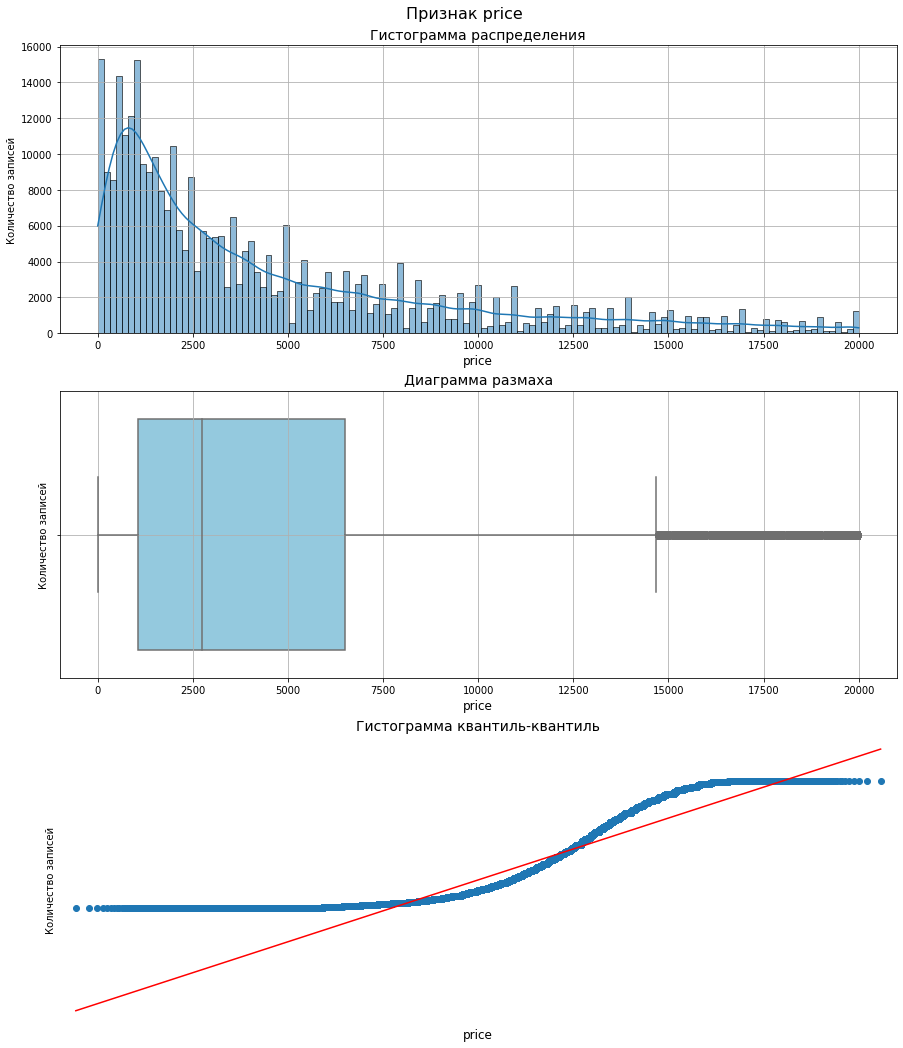

In [79]:
# Рассмотрим признак price

feature_hist_qq_box(auto, 'price')

Медиана признака составляет 2700 евро.
Значения цены выше 15 000 не типичны, но выбросами их тоже не назовешь, число довольно велико.
Распределение не является нормальным.

Проверим нормальность распределения тестами

In [80]:
feature_distribution(auto, 'price')

Тест Шапиро-Уилка = ShapiroResult(statistic=0.8299920558929443, pvalue=0.0)
Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения. 

Тест Д Агостино = NormaltestResult(statistic=73001.0678035573, pvalue=0.0)
Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения. 

Коэффициент асимметрии = 1.4144401220372471
Положительная асимметрия: хвост находится в правой части.
Распределение простирается в сторону более положительных значений.


In [81]:
# Сколько в файле автомобилей с ценой выше 20 000

auto[auto['price'] >= 20000]['price'].count()

245

In [82]:
# Посмотрим, что это за машины

auto[auto['price'] >= 20000].sort_values(by = ['price', 'registration_year'], ascending = False)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
12580,2016-03-23,20000,sedan,2016,manual,110,a3,5000,0,petrol,audi,unknown,2016-03-23,0,4299,2016-04-03
26103,2016-04-01,20000,suv,2016,auto,155,rav,5000,3,hybrid,toyota,no,2016-04-01,0,60314,2016-04-02
346165,2016-03-25,20000,coupe,2016,auto,507,m_reihe,150000,6,petrol,bmw,unknown,2016-03-25,0,94032,2016-04-02
63866,2016-03-12,20000,sedan,2015,manual,208,2_reihe,20000,9,petrol,peugeot,no,2016-03-12,0,56766,2016-04-05
95512,2016-03-08,20000,small,2015,manual,90,a1,20000,3,gasoline,audi,no,2016-03-08,0,12347,2016-04-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101861,2016-03-09,20000,sedan,1960,auto,0,other,150000,0,petrol,ford,unknown,2016-03-09,0,17424,2016-03-14
321204,2016-03-27,20000,sedan,1960,manual,0,unknown,150000,0,petrol,sonstige_autos,unknown,2016-03-27,0,92331,2016-04-07
83020,2016-03-30,20000,sedan,1950,manual,0,unknown,5000,3,petrol,sonstige_autos,unknown,2016-03-30,0,48455,2016-04-05
174278,2016-03-28,20000,sedan,1936,manual,23,other,30000,0,petrol,opel,unknown,2016-03-28,0,66879,2016-04-06


Здесь пока оставим все как есть.

In [83]:
# Сколько в файле автомобилей с ценой 0

auto[auto['price'] ==0]['price'].count()

9762

Эти записи стоит удалить. Если в целевом признаке ноль, то тут модель ничему хорошему не обучится.

In [84]:
auto = auto[auto['price'] > 0]

In [85]:
# Сколько осталось строк

auto.shape[0]

319690

In [86]:
# В % от исходного
rate(auto)

90.21387310966817

In [87]:
auto['price'].median()

2900.0

После удаления нулей, медианное значение целы составляет 2 890 евро.

Медиана признака = 2003.0


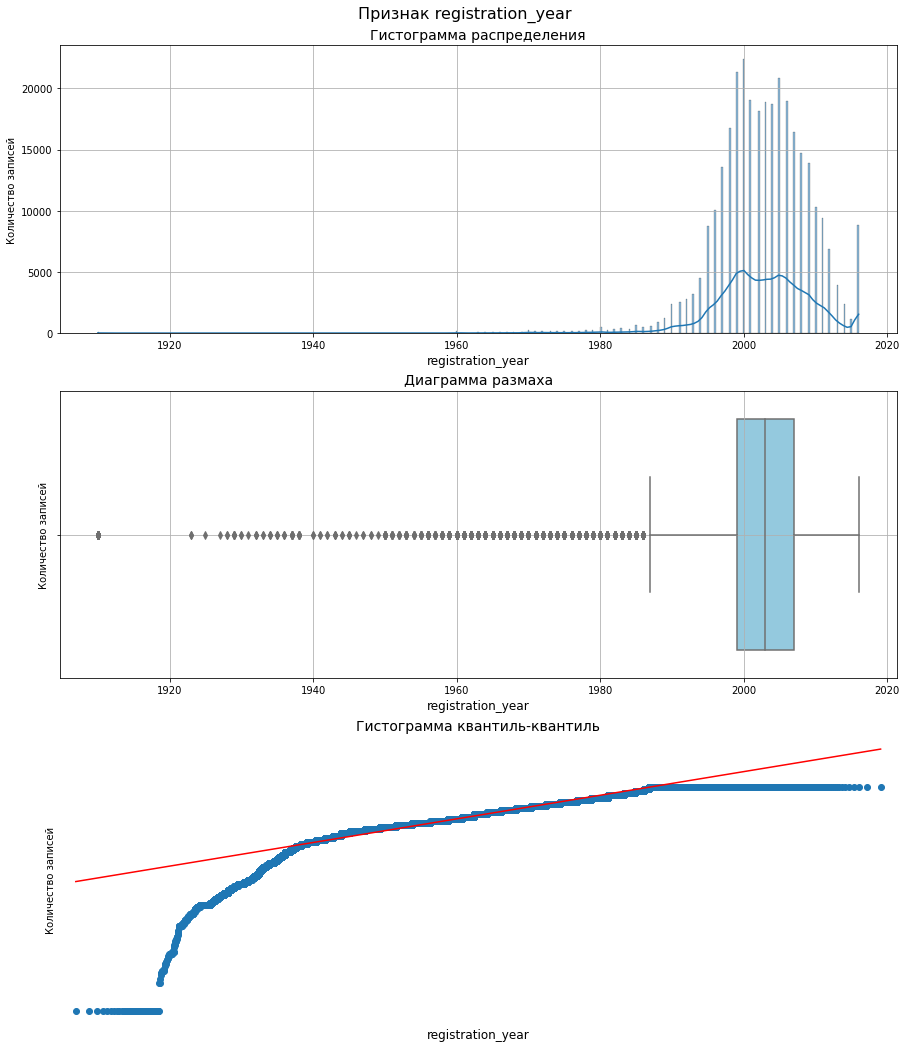

In [88]:
# Рассмотрим признак registration_year

feature_hist_qq_box(auto, 'registration_year')

In [89]:
feature_distribution(auto, 'registration_year')

Тест Шапиро-Уилка = ShapiroResult(statistic=0.9140556454658508, pvalue=0.0)
Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения. 

Тест Д Агостино = NormaltestResult(statistic=131672.15255597077, pvalue=0.0)
Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения. 

Коэффициент асимметрии = -1.6101229990304076
Отрицательная асимметрия: хвост находится в левой части.
Распределение простирается в сторону более отрицательных значений.


График не распределен нормально. Исходя из гистограммы распределения, значения до ~1985 года не типичны. Исходя из здравого смысла, я бы, пожалуй, не принимала в рассмотрение машины в датой регистрации до 1990 года: это или антикварные автомобили (если наиболее ранние даты), или совсем уж устаревшие (на запчасти).
Пожалуй, ограничим нижний предел 1985 годом.

Медианное значение = 2003 год.

In [90]:
# Найдем количество машин старше 34-х лет

auto[auto['registration_year'] <= 1985]['price'].count()

5482

In [91]:
# Оставим в файле даты регистрации от 1985

auto = auto[auto['registration_year']>1985]

Медиана признака = 2003.0


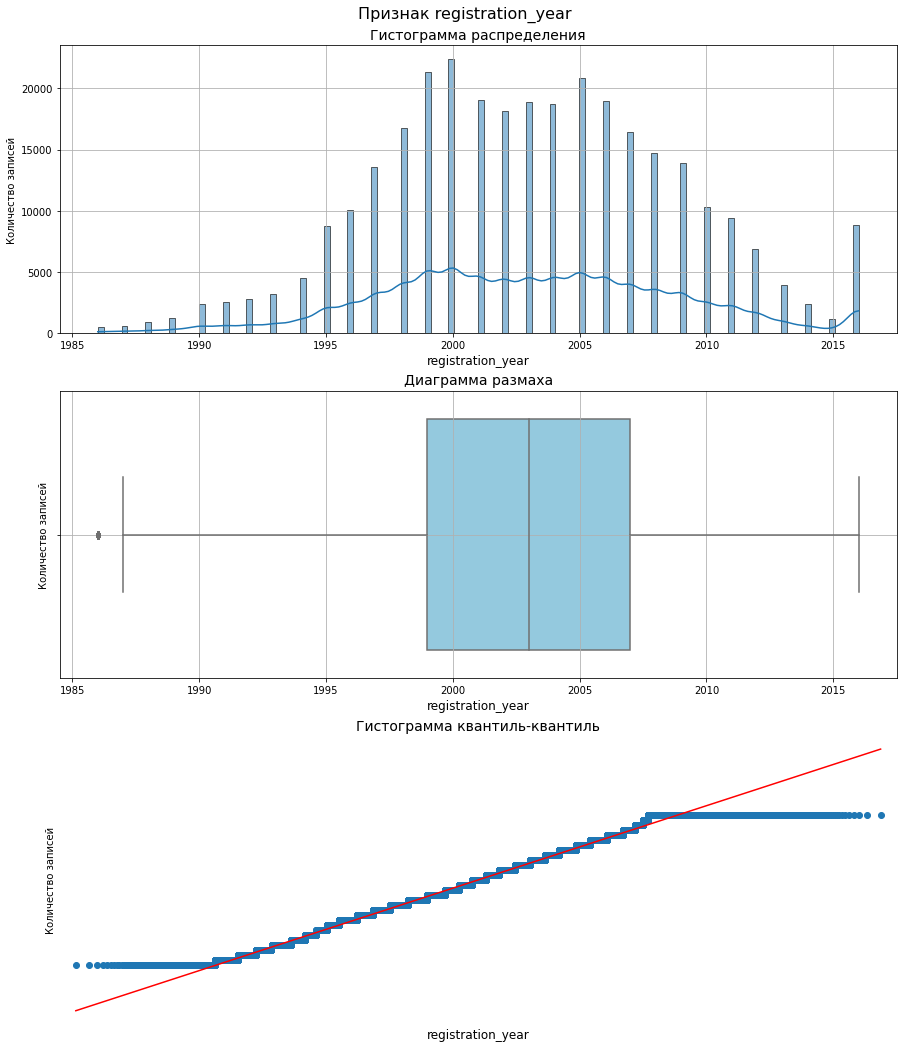

In [92]:
# И еще раз визуально

feature_hist_qq_box(auto, 'registration_year')

Получается три пика: 2000, 2005 и 2017 годы.

Медианное значение 2003.

Медиана признака = 105.0


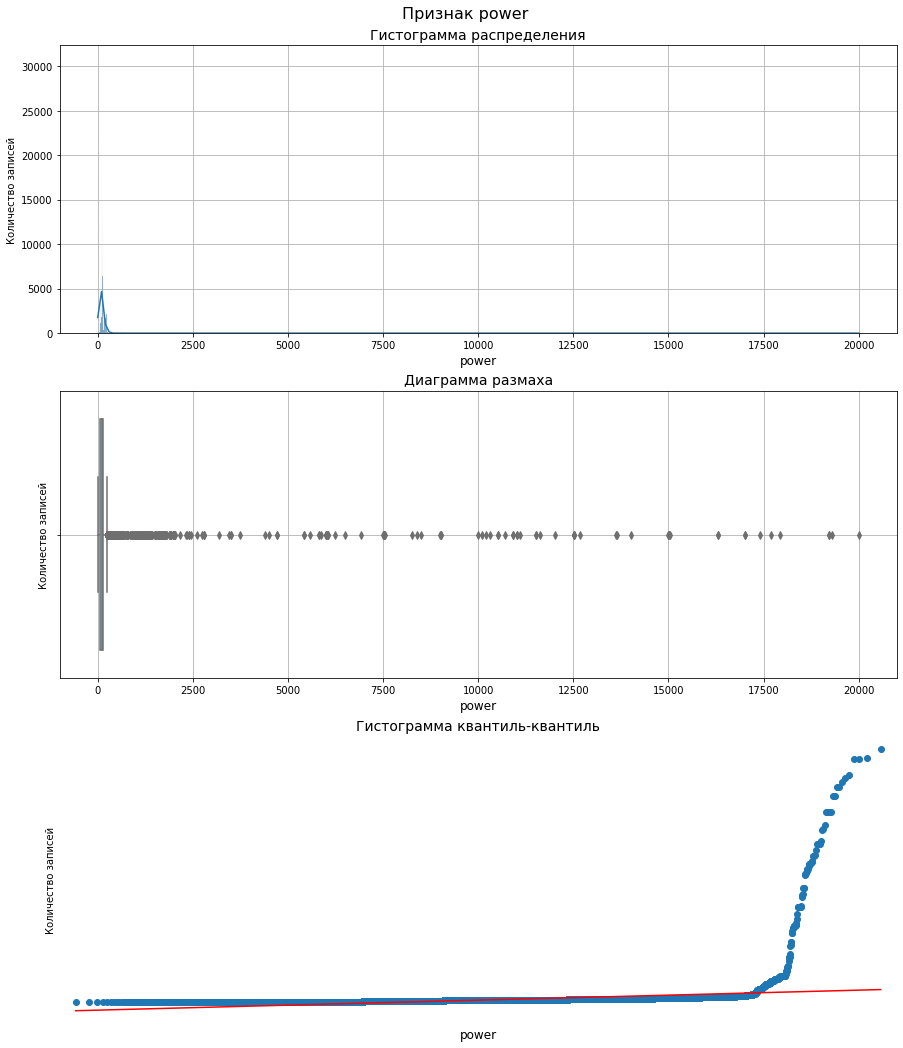

In [93]:
# Рассмотрим признак power

feature_hist_qq_box(auto, 'power')

Признак power явно имеет выбросы. (Тк. у карьерного погрузчика катерпиллар мощность не более 4к., а тут до 20 доходит, даже если это внедорожники, многовато).
Путем нескольких итераций графика ниже...
..Оставим значение до 2 500..

UPD: Оставляем значения от 9л.с.(самая маленькая модель ситроен) до 750л.с. - это самые мощные машины на 2017 год.

Медиана признака = 105.0


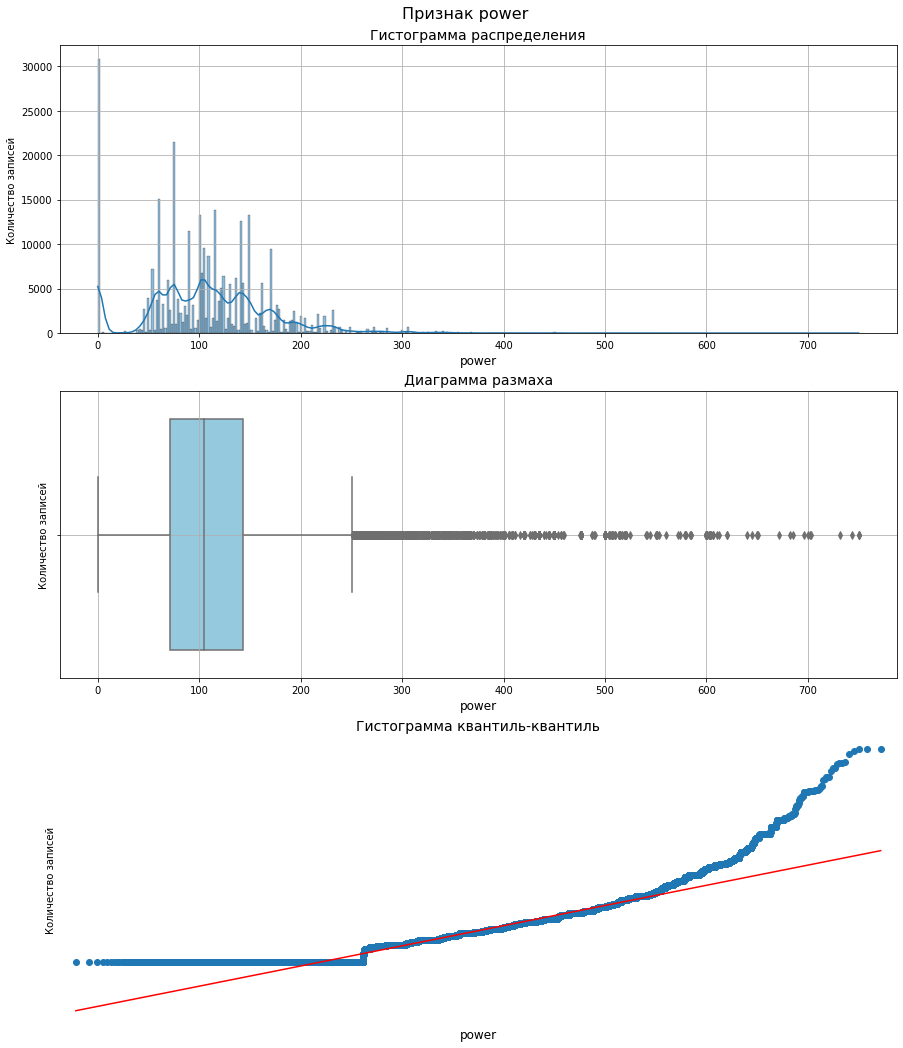

In [94]:
# Рассмотрим признак power

feature_hist_qq_box(auto[(auto['power'] <=750)], 'power')

In [95]:
feature_distribution(auto, 'power')

Тест Шапиро-Уилка = ShapiroResult(statistic=0.15497851371765137, pvalue=0.0)
Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения. 

Тест Д Агостино = NormaltestResult(statistic=1067482.2886361838, pvalue=0.0)
Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения. 

Коэффициент асимметрии = 62.54851884690909
Положительная асимметрия: хвост находится в правой части.
Распределение простирается в сторону более положительных значений.


График не распределен нормально.

Если это самые продвинутые модели, то их мощность может достигать 725 л.с. В нашем случае Боксплот показывает, что около 500 - это уже скорее аномально высокие значения.

В 1970е годы срденяя мощность автомобиля составляла 96 л.с. Поскольку мы выбрали отправной датой для анализа 1970г., то модели с мощностью менее 30л.с , полагаю, можно убрать из таблицы.

Нулевые значения мощности, хоть их и очень много также придется удалить, поскольку это важный показатель, от которого зависит цена. А заполнять средним, например, эти нули, я бы не стала, поскольку, может машина, действительно, "не на ходу". (В Германии в частности, были крупные наводнения в 2000 и 2005, 2017гг).

In [96]:
# Сколько машин с мощностью 0 л.с.

auto[(auto['power']<=0)]['price'].count()

30790

In [97]:
# В % от исходного объема это
(auto[(auto['power']<=0)]['price'].count()/origin)*100

8.688683265184032

In [98]:
# Сколько машин с мощностью до 30 л.с.

auto[(auto['power']>0)&(auto['power']<=9)]['price'].count()

194

In [99]:
# Сколько машин с аномально высокой мощностью

auto[(auto['power']>750)]['price'].count()

284

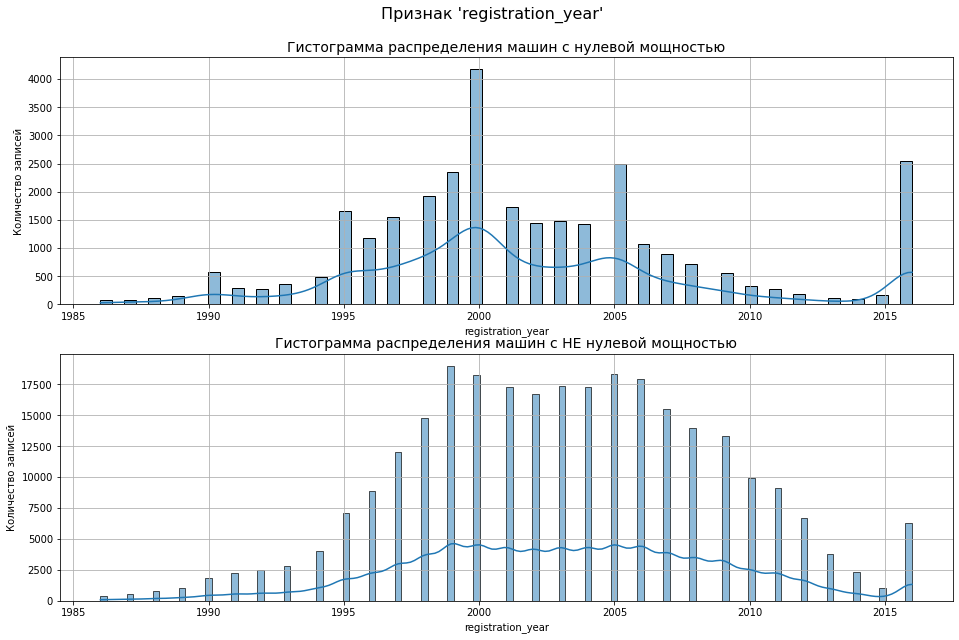

In [100]:
# Посмотрим, как распределена нулевая мощность по годам выпуска машин

fig, axes = plt.subplots(2,1, figsize=(16,10))
fig.suptitle(f"Признак 'registration_year'", size=16, y=0.95)
    
sns.histplot(x=auto.query('power==0')['registration_year'], ax=axes[0], kde=True, bins='auto');   
axes[0].set_title(f'Гистограмма распределения машин с нулевой мощностью', fontsize=14)
#axes[0].set_xlabel('year', fontsize=12)
axes[0].set_ylabel('Количество записей')
axes[0].grid()

sns.histplot(x=auto.query('power!=0')['registration_year'], ax=axes[1], kde=True, bins='auto');   
axes[1].set_title(f'Гистограмма распределения машин с НЕ нулевой мощностью', fontsize=14)
#axes[1].set_xlabel('year', fontsize=12)
axes[1].set_ylabel('Количество записей')
axes[1].grid()

fig.show()

Итак, машин с нулевой мощностью у нас в файле около 10%. Распределены они по всем рассматриваемым годам выпуска.

Показатель важный. Как будет понятно позже по матрице корреляций - основной, который влияет на цену.
Оставлять нулевые значения не имеет смысла, чтобы не путать модель информационным шумом.

... После долгих размышлений, полагаю, что лучше данные с нулевой мощностью удалить.

Удаляем.

In [101]:
auto = auto[(auto['power']>9)&(auto['power']<=750)]

Рейтинг самых маломощных автомобилей мира

1. Peel P50 - 4,2л.с., производился в 60-х годах.

2. Citroen 2CV - 9 л.с, производился до 1990г. - это близко к нашей нижней границе года регистрации. ВОзьмем 9л.с. в качестве нижней границы мощности

а вот про 1-2 л.с. не нашла

In [102]:
# Остается от исходных данных

rate(auto)

79.84332715333451

In [103]:
# И медиана мощности на скорректированных данных составляет:

auto['power'].median()

112.0

Медиана признака = 150000.0


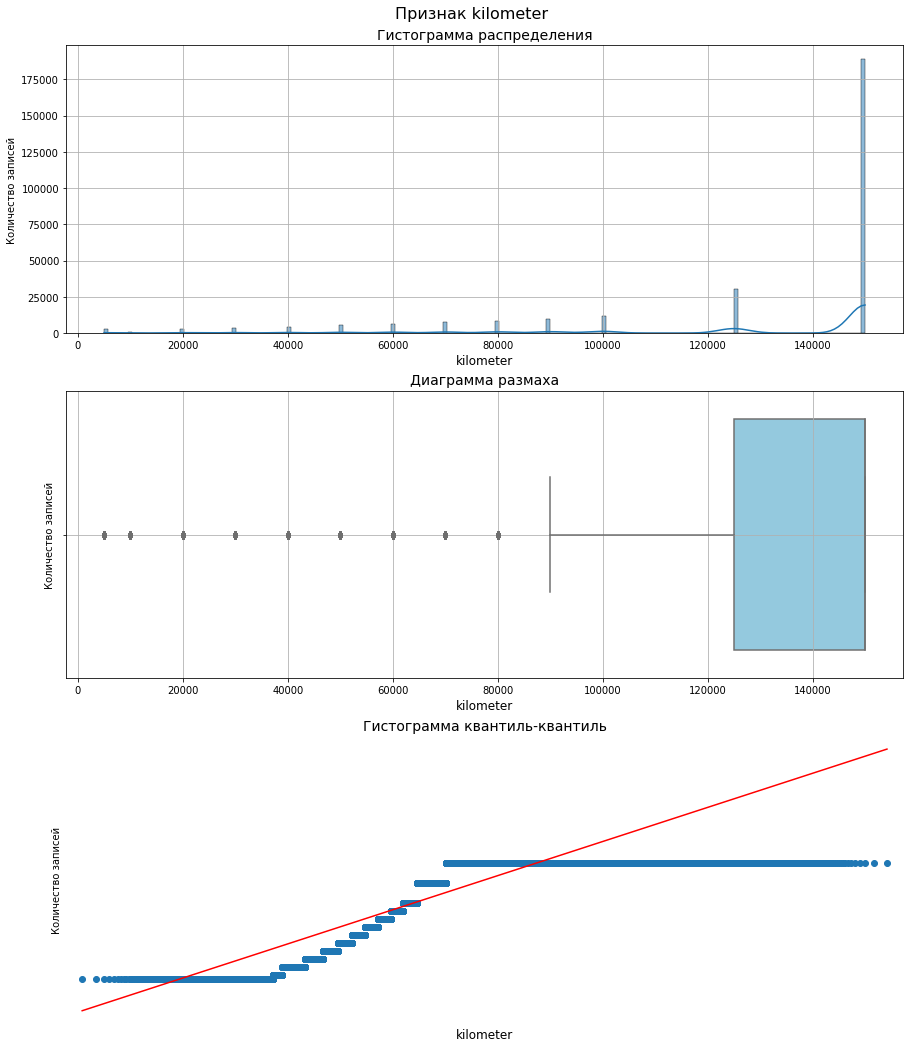

In [104]:
# Рассмотрим признак kilometer

feature_hist_qq_box(auto, 'kilometer')

In [105]:
feature_distribution(auto, 'kilometer')

Тест Шапиро-Уилка = ShapiroResult(statistic=0.6464372873306274, pvalue=0.0)
Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения. 

Тест Д Агостино = NormaltestResult(statistic=78698.23458363758, pvalue=0.0)
Есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения. 

Коэффициент асимметрии = -1.6733215329403341
Отрицательная асимметрия: хвост находится в левой части.
Распределение простирается в сторону более отрицательных значений.


Медиана составляет 150 000 км, поскольку машины у нас подержанные, возрастом до 35 лет. График не распределен нормально, признак дискретный - в объявлениях указывают обычно округленные значения.

Посмотрим, что творится на 150 000 км

In [106]:
auto[auto['kilometer']>=150000]['price'].count()

189112

Это основная часть автомобилей.

In [107]:
# Число машин с пробегом меньше 20 000 км

auto[auto['kilometer'] < 20000]['price'].count()

3404

In [108]:
auto[auto['kilometer'] < 20000].sort_values(by = 'registration_year'
                                            #, ascending = False
                                           )

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
258125,2016-03-23,3325,convertible,1986,manual,170,3er,5000,3,petrol,bmw,yes,2016-03-23,0,85084,2016-04-05
276653,2016-03-05,3499,convertible,1986,manual,26,601,5000,12,petrol,trabant,no,2016-03-05,0,9244,2016-03-12
78755,2016-04-04,4799,small,1986,manual,50,601,5000,1,petrol,trabant,no,2016-04-04,0,9117,2016-04-06
129943,2016-03-16,7800,suv,1986,manual,68,unknown,10000,12,gasoline,sonstige_autos,unknown,2016-03-16,0,6886,2016-03-28
270057,2016-03-14,600,small,1986,manual,55,polo,5000,0,petrol,volkswagen,no,2016-03-14,0,96148,2016-04-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269082,2016-03-23,9990,small,2016,manual,80,micra,5000,3,petrol,nissan,no,2016-03-23,0,41334,2016-03-31
42330,2016-03-16,12500,small,2016,manual,110,fabia,5000,2,petrol,skoda,no,2016-03-16,0,64579,2016-04-07
205789,2016-03-16,15690,small,2016,manual,95,a1,5000,3,petrol,audi,no,2016-03-16,0,72793,2016-04-06
154813,2016-03-20,18900,coupe,2016,auto,48,fortwo,5000,0,electric,smart,no,2016-03-20,0,86368,2016-04-06


Интересно получается. у машин с самым малым пробегом попадается нелепо низкая цена. 

По пробегу удалять ничего не будем, тут могут быть самые разные варианты.

#### Категориальные признаки

Учитывая пропуски в данных, построим графики для категориальных признаков.

In [109]:
# Список категориальных признаков без марки и бренда

cat_cols = cat_cols.drop(['model', 'brand'])

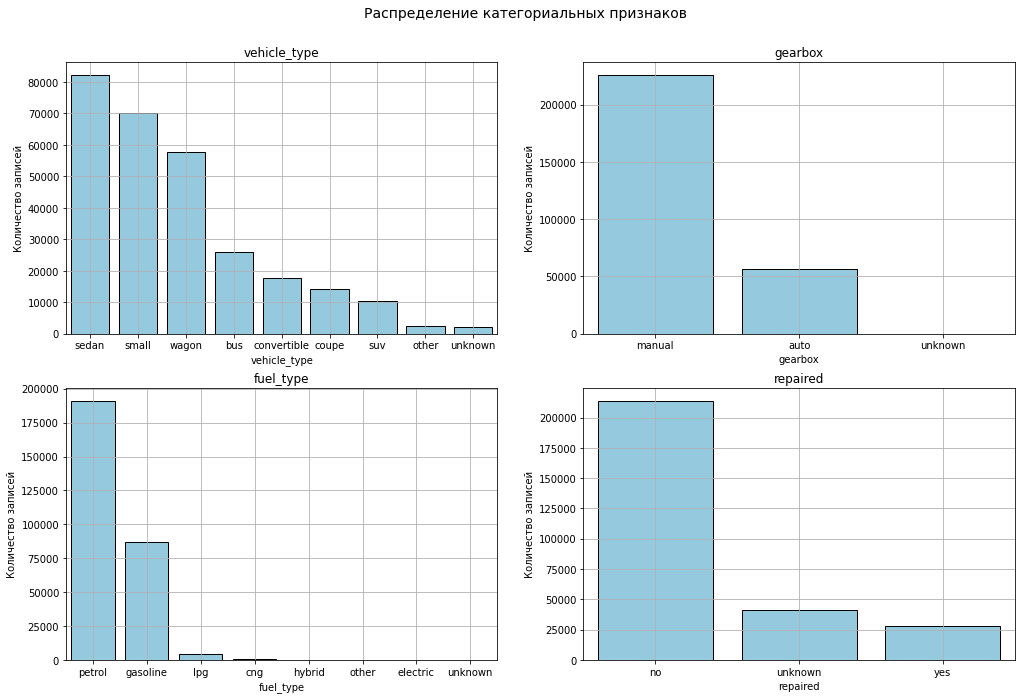

In [110]:
# Категориальные признаки

# Названия графиков
plot_titles = cat_cols

# Подписи для осей X и Y
x_labels = cat_cols

y_labels = ['Количество записей']*len(cat_cols)

# Используем цикл для построения гистограмм каждого признака
fig, axs = plt.subplots(2, 2, figsize=(17, 11))
axs = axs.flatten()
fig.suptitle(f"Распределение категориальных признаков", size=14, y=0.95)

features = cat_cols

for i, feature in enumerate(features):
    sns.countplot(x = auto[feature], order = auto[feature].value_counts().index, color='SkyBlue', edgecolor='black', ax=axs[i])
    axs[i].set_title(plot_titles[i], fontsize=12)
    axs[i].set_xlabel(x_labels[i], fontsize=10)
    axs[i].set_ylabel(y_labels[i], fontsize=10)
    axs[i].grid(True)
    
plt.show();

По типу кузова лидирует седан. На втором месте - small, судя по всем данным, это небольшие городские машины, обычно хэтч-бэк. На третьем месте - универсал. Меньше всего (из обозначенных) - внедорожников.
Коробка передач у большей части машин ручная, у ~ 1/6 автомат. Машины в основном на бензине, ~ 1/3 - газ, остальные виды - ничтожное количество.
Подавляющая часть автомобилей после ремонта. Без ремонта заявлены ~ 1/7.

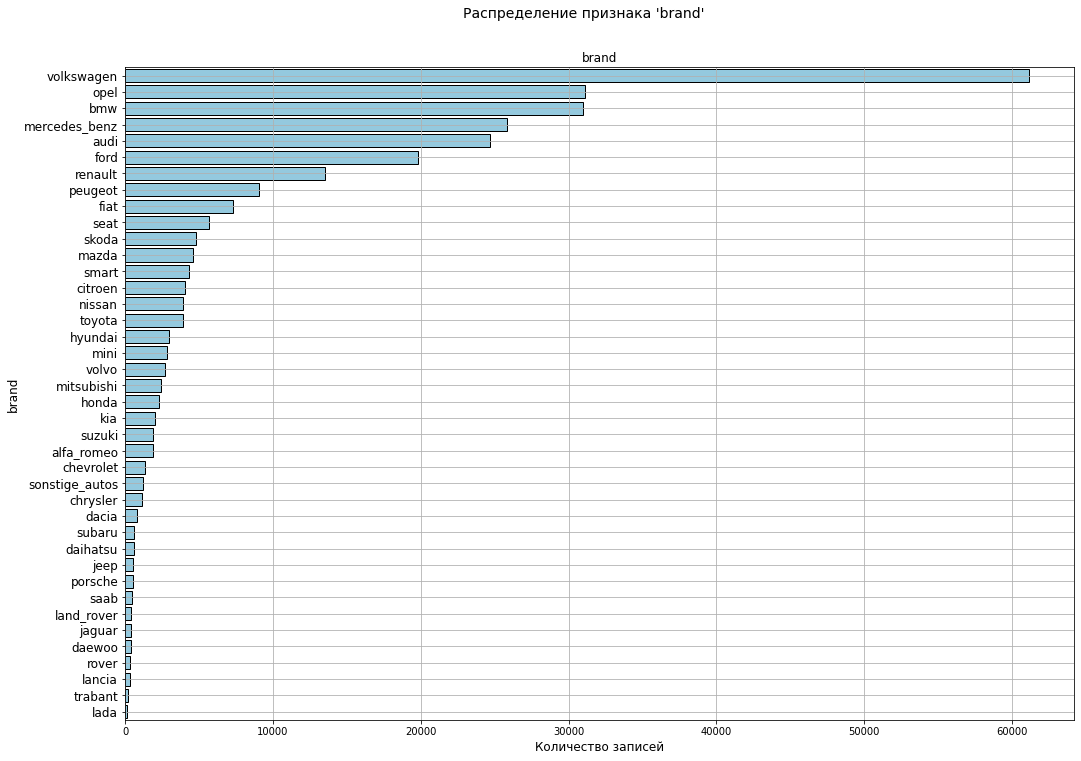

In [111]:
# Категориальный признак 'brand'

# Названия графиков
plot_titles = 'brand'

# Подписи для осей X и Y
y_labels = 'brand'

x_labels = ['Количество записей']

# Используем цикл для построения гистограмм каждого признака
fig, axs = plt.subplots(1, 1, figsize=(17, 12))
#axs = axs.flatten()
fig.suptitle(f"Распределение признака 'brand'", size=14, y=0.95)

features = 'brand'

#for i, feature in enumerate(features):
sns.countplot(y = auto['brand'], order = auto['brand'].value_counts().index, color='SkyBlue', edgecolor='black', ax=axs)
axs.set_title('brand',  fontsize=12)
axs.set_ylabel('brand', fontsize=12)
axs.set_xlabel(x_labels[0], fontsize=12)
axs.grid(True)
plt.yticks(fontsize=12)

plt.show();

Самая популярная марка - volkswagen, безусловный лидер. (Очевидно, данные немецкие. Лада на уровне трабанта намекает на это самым явным образом.)

In [112]:
# Первая пятерка:

auto['brand'].value_counts().to_frame().reset_index().sort_values(by = 'brand', ascending = False).head(5)

,index,brand
0,volkswagen,61134
1,opel,31103
2,bmw,30970
3,mercedes_benz,25818
4,audi,24715


1е место - Народный автомобиль! Как и было заявлено, при запуске этого бренда. Опель и БМВ составляют почти в 2 раза меньшее количество.

Абсолютные аутсайдеры: трабант и лада (тут уж без комментариев)

#### Удаление бессмысленных колонок

Итак, к этому моменту, мы приходим к выводу, что некоторые колонки в файле не имеют смысла, и лишь вносят бесполезный шум в данные.

Предлагаю, на данном этапе от них избавиться.

registration_month - какой прок в месяце регистрации автомобилей, если остальные даты у нас кто в лес, кто по дрова. На анализ цен на подержанные машины он вряд ли повлияет.

Удаляем колонки: number_of_pictures, date_crawled, date_created, last_seen, registration_month

UPD: Почтовый код тоже удалила, тк по итогу он оказался не важен.

In [113]:
auto = auto.drop(['date_crawled', 'date_created', 'number_of_pictures', 'last_seen', 'postal_code'], axis=1)

In [114]:
auto.head(3)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no


Выглядит гораздо приятнее.

Проверим дубликаты

In [115]:
auto[auto.duplicated(keep='first')]['price'].count()

15161

In [116]:
auto[auto.duplicated(keep=False)].sort_values(by='registration_year', ascending = False)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
136410,999,unknown,2016,manual,102,a_klasse,150000,3,petrol,mercedes_benz,no
322244,4590,small,2016,manual,75,2_reihe,125000,11,petrol,peugeot,no
308166,16200,sedan,2016,auto,114,other,5000,4,petrol,renault,no
25203,400,sedan,2016,manual,75,golf,150000,0,petrol,volkswagen,unknown
156294,1549,small,2016,manual,58,corsa,150000,3,petrol,opel,unknown
...,...,...,...,...,...,...,...,...,...,...,...
249767,1200,sedan,1986,manual,54,golf,150000,5,gasoline,volkswagen,no
82051,1250,sedan,1986,auto,90,80,150000,7,petrol,audi,yes
208934,1200,sedan,1986,manual,54,golf,150000,5,gasoline,volkswagen,no
276653,3499,convertible,1986,manual,26,601,5000,12,petrol,trabant,no


Удалим их, чтобы не путать модель при обучении.

In [117]:
#Удалим дубликаты

auto = auto.drop_duplicates(keep='first')

In [118]:
#Доля оставшихся данных от исходного числа

rate(auto)

75.56501838479099

#### Взаимосвязи данных

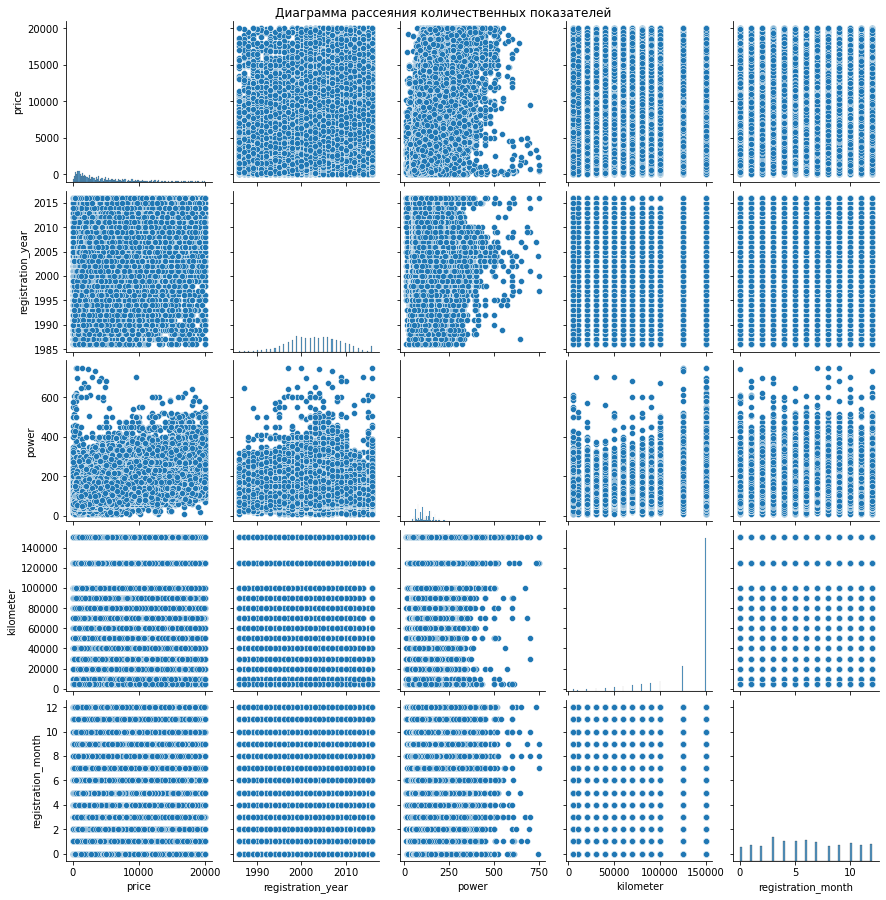

In [119]:
# Диаграмма рассеяния количественных показателей

pair_plot = sns.pairplot(auto
                         #, kind="kde",  corner=True
                        )

pair_plot.fig.suptitle('Диаграмма рассеяния количественных показателей', y=1.0)
plt.show(); 

Никаких линейных зависимостей!

Рассмотрим корреляции с коээфициентами Спирмана и Фи.

(Пирсон  здесь не подходит, т.к. ни один из параметров не распределен нормально)

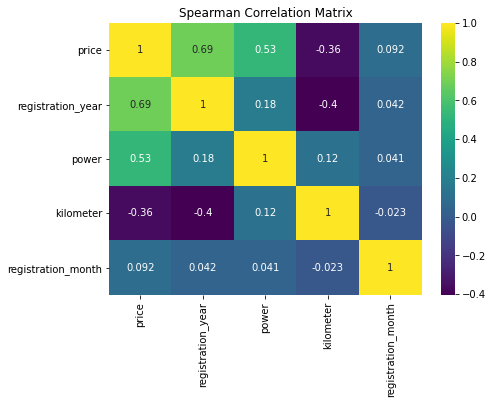

In [120]:
# Матрица корреляции числовых признаков Спирмана

fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(auto.corr(method='spearman'), annot=True, cmap='viridis')
plt.title('Spearman Correlation Matrix');

Из числовых признаков наибольшая корреляция с годом регистрации автомоблиля и мощностью.

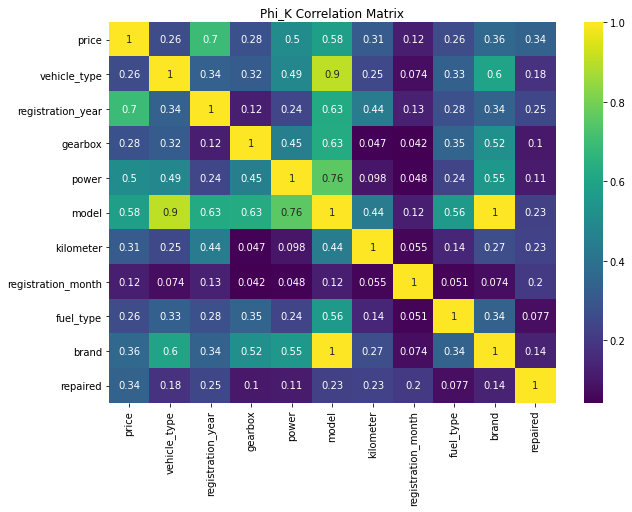

In [121]:
# Матрица корреляции Фи в целом для всех данных 

fig, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(auto.phik_matrix(verbose=False), annot=True, cmap='viridis')

plt.title('Phi_K Correlation Matrix');

Итак, с учетом всех факторов, у нас есть Мультиколлинеарность:
* корреляция = 1: бренд и модель
* корреляция = 0,92: модель и типа кузова. 

Корреляции же выявлены следующие:
* высокая (0,7) с годом регистрации
* выше среднего (0,58 и 0,53) с моделью и мощностью
* ниже среднего / умеренная корреляция - со всеми остальными признаками, кроме почтового кода.

Почтовый код не однозначный: в числовых признаках он на 3м месте по корреляции с ценой, в общем объеме признаков у него наименьшая корреляция из всех.

В модели стоит удалить признак "модель" - чтобы убрать мультиколлинеарность.

#### Подготовка данных для моделей + Pipeline

Подготовим данные для работы моделей.

In [122]:
# Определим целевой признак и признаки, которые нужно исключить из выборки

target = 'price'
drop_columns = ['price','model'] # Пока оставим это поле пустым

In [123]:
# Создадим функцию для разделения датасета на выборки

def data_split(df, target, test_size, drop_columns):
    
    X = df.drop(columns=drop_columns, axis=1)
    y = df[target]
    
    # Для разбивки на 2 выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    return X_train, X_test, y_train, y_test

In [124]:
# разбиваем датасет на тренировочную и валидационную выборки

X_train, X_valid, y_train, y_valid = data_split(auto, target=target, test_size=VALID_SIZE, drop_columns=drop_columns)

In [125]:
#Проверим размер выборок

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(200834, 9) (200834,) (66945, 9) (66945,)


In [126]:
# разбиваем датасет на валидационную и тестовую выборки

X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=TEST_2_SIZE)

In [127]:
#Проверим размер выборок

print(X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(33472, 9) (33472,) (33473, 9) (33473,)


In [128]:
# Проверим, что строки не потерялись

X_train.shape[0]+X_valid.shape[0]+X_test.shape[0]==auto.shape[0]

True

Перейдем к пайплайну.

Для начала определим три типа колонок для кодировщиков: категориальные номинальные, категориальные порядковые и числовые.

In [129]:
# Зададим числовые колонки:

num_code_cols = auto.drop(drop_columns, axis=1).select_dtypes(include='number').columns
num_code_cols

Index(['registration_year', 'power', 'kilometer', 'registration_month'], dtype='object')

In [130]:
check_code_cols = auto.drop(drop_columns, axis=1).select_dtypes(exclude='number').columns
check_code_cols

Index(['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired'], dtype='object')

С категориальными признаками поступим следующим образом: в качестве номинальных возьмем коробку передач и признак ремонта, потому что в них всего по 2 значения (3 с unknown).

И чтобы не разгонять признаки, остальные закодируем как ранговые (хоть они и не являются ранговыми по определению).

In [131]:
# Создадим список номинальных категориальных признаков

cat_ohe_cols = ['gearbox', 'repaired']

In [132]:
# Создадим список ранговых категориальных признаков и категории
# Пока что он будет пустым

cat_ord_cols = ['vehicle_type', 'brand', 'fuel_type']
categories = [['coupe', 'suv', 'small', 'sedan', 'convertible', 'bus', 'wagon',
       'unknown', 'other'], ['audi', 'jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'lancia', 'toyota', 'chevrolet', 'dacia', 'suzuki',
       'daihatsu', 'chrysler', 'jaguar', 'daewoo', 'rover', 'porsche',
       'saab', 'land_rover', 'trabant', 'lada'], ['gasoline', 'petrol', 'lpg', 'other', 'hybrid', 'cng', 'unknown',
       'electric']]

In [133]:
#auto['fuel_type'].unique()

Добавляем кодирование качественных номинальных признаков спомощью OneHotEncoder. Пропуски заполняем самым частым значением с помощью SimleImputer.

In [134]:
# SimpleImputer + OHE

ohe_pipe = Pipeline([('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),\
                     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]) 

Добавляем кодирование качественных порядковых признаков с помощью OrdinalEncoder. Пропуски до и после кодирования также заполняем самым частым значением с помощью SimleImputer.

In [135]:
# SimpleImputer + ORD + SimpleImputer
# categories : alphabetically

ord_pipe = Pipeline([('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('ord', OrdinalEncoder(categories=categories,
                                            handle_unknown='use_encoded_value', unknown_value=np.nan)),
                     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))]) 

Объединим кодирование и масштабирование - ohe_pipe, ord_pipe, в пайплайн с подготовкой данных = data_preprocessor.

In [136]:
# Создаем пайплайн для обработки данных

data_preprocessor = ColumnTransformer([('ohe', ohe_pipe, cat_ohe_cols),
                                       ('ord', ord_pipe, cat_ord_cols),
                                       ('num', StandardScaler(), num_code_cols)],
                                      remainder='passthrough') 

Создадим итоговый пайплайн подготовки данных и обучения модели.

В качестве отправной точки возьмем Линейную регрессию.

In [137]:
# Итоговый пайплайн: подготовка данных и модель Линейная регрессия)

pipe_final = Pipeline([('preprocessor', data_preprocessor),
                       ('models', LinearRegression(fit_intercept=True))]) 

## Обучение моделей

#### Модель 1: Линейная регрессия

In [138]:
# Для Линейной регрессии:

pipe_lr = Pipeline([('preprocessor', data_preprocessor),
                       ('models', LinearRegression())]) 

In [139]:
%%time
start = time.time()

pipe_lr.fit(X_train, y_train)

end = time.time()
learning_time_lr=end-start

start = time.time()

pipe_lr_pred = pipe_lr.predict(X_valid)

end = time.time()
pred_time_lr = end-start

rmse_lr = mean_squared_error(y_valid, pipe_lr_pred, squared=False)
print(f'Метрика RMSE LinearRegression = {rmse_lr:.4f}', '\n')
print(f'Время обучения LinearRegression = {learning_time_lr:.4f}')
print(f'Время предсказания LinearRegression = {pred_time_lr:.4f}')

Метрика RMSE LinearRegression = 2751.3640 

Время обучения LinearRegression = 0.5170
Время предсказания LinearRegression = 0.1896
CPU times: user 639 ms, sys: 88.2 ms, total: 727 ms
Wall time: 708 ms


In [140]:
# Сохраним тренировочную выборку с закодированными колонками

X_train_pre = pd.DataFrame(data_preprocessor.fit_transform(X_train), columns=data_preprocessor.get_feature_names_out())
X_test_pre = pd.DataFrame(data_preprocessor.transform(X_test), columns=data_preprocessor.get_feature_names_out())

#### Модель 2: Дерево решений

In [141]:
# Рассмотрим модель Дерево решений

pipe_dt = Pipeline([('preprocessor', data_preprocessor),
                       ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))]) 

In [142]:
%%time
start = time.time()

pipe_dt.fit(X_train, y_train)

end = time.time()

learning_time_dt=end-start

start = time.time()

pipe_dt_pred = pipe_dt.predict(X_valid)

end = time.time()
pred_time_dt = end-start

rmse_dt = mean_squared_error(y_valid, pipe_dt_pred, squared=False)
print(f'Метрика RMSE DecisionTreeRegressor = {rmse_dt:.4f}', '\n')
print(f'Время обучения DecisionTreeRegressor = {learning_time_dt:.4f}')
print(f'Время предсказания DecisionTreeRegressor = {pred_time_dt:.4f}')

Метрика RMSE DecisionTreeRegressor = 2130.0238 

Время обучения DecisionTreeRegressor = 1.2969
Время предсказания DecisionTreeRegressor = 0.0770
CPU times: user 1.35 s, sys: 19.8 ms, total: 1.37 s
Wall time: 1.38 s


#### Модель 3: Гиперпараметры

In [143]:
# Зададим гиперпараметры пайплайна

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 5),
        'models__min_samples_leaf': range(1, 4),
        'models__max_features': range(1, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
   # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],     
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели RandomForestRegressor() 
    { 
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)], 
        'models__max_depth': range(1, 5), 
        'models__min_samples_leaf': range(1, 4), 
        'models__max_features': range(1, 7), 
        'models__n_estimators': range(1, 150), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]

In [144]:
%%time
start = time.time()

pipe_rscv = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring = 'neg_root_mean_squared_error', 
    random_state=RANDOM_STATE, 
    n_jobs=-1,
    #refit='neg_root_mean_squared_error'
)

pipe_rscv.fit(X_train, y_train) 

end = time.time()
learning_time_rscv=end-start

start = time.time()

pipe_rscv_pred = pipe_rscv.best_estimator_.predict(X_valid)

end = time.time()
pred_time_rscv=end-start

rmse_rscv = root_mean_squared_error(y_valid, pipe_dt_pred)
print(f'Лучшая модель и ее параметры: \n\n', pipe_rscv.best_params_, '\n')
print(f'Метрика лучшей модели при кросс-валидации: ', round(-pipe_rscv.best_score_, 4))
print(f'Метрика на тестовой выборке: {rmse_rscv:.4f}', '\n')
print(f'Время обучения с RandomizedSearchCV = {learning_time_rscv:.4f}')
print(f'Время предсказания с RandomizedSearchCV = {pred_time_rscv:.4f}')

Лучшая модель и ее параметры: 

 {'preprocessor__num': RobustScaler(), 'models__n_estimators': 135, 'models__min_samples_leaf': 3, 'models__max_features': 5, 'models__max_depth': 4, 'models': RandomForestRegressor(random_state=45)} 

Метрика лучшей модели при кросс-валидации:  2404.4651
Метрика на тестовой выборке: 2130.0238 

Время обучения с RandomizedSearchCV = 181.4105
Время предсказания с RandomizedSearchCV = 0.2073
CPU times: user 3min, sys: 505 ms, total: 3min 1s
Wall time: 3min 1s


**(на случай, если лень ждать, пока найдется модель):**

Лучшая модель и ее параметры: 

 {'preprocessor__num': 'passthrough', 'models__n_estimators': 144, 'models__max_features': 4, 'models__max_depth': 39, 'models': RandomForestRegressor(random_state=45)} 

Метрика лучшей модели при кросс-валидации:  1628.4597
Метрика на тестовой выборке: 1604.2961 

Время обучения LinearRegression RSCV = 798.4989 секунд
CPU times: user 13min 9s, sys: 9.86 s, total: 13min 19s
Wall time: 13min 20s

#### Модель 4: Градиентный бустинг CatBoostRegressor

In [145]:
# Рассмотрим модель CatBoostRegressor в пайплайне

pipe_cat = Pipeline([('preprocessor', data_preprocessor),
                       ('models', CatBoostRegressor(random_state=RANDOM_STATE, verbose=False))]) 

In [146]:
%%time
start = time.time()

pipe_cat.fit(X_train,y_train)

end = time.time()
learning_time_cat=end-start

start = time.time()

pipe_cat_pred = pipe_cat.predict(X_valid)
end = time.time()
pred_time_cat=end-start

rmse_cat = mean_squared_error(y_valid, pipe_cat_pred, squared=False)
print(f'Метрика RMSE CatBoostRegressor = {rmse_cat:.4f}', '\n')
print(f'Время обучения CatBoostRegressor = {learning_time_cat:.4f}')
print(f'Время предсказания CatBoostRegressor = {pred_time_cat:.4f}')

Метрика RMSE CatBoostRegressor = 1595.8864 

Время обучения CatBoostRegressor = 27.4370
Время предсказания CatBoostRegressor = 0.1787
CPU times: user 26.2 s, sys: 260 ms, total: 26.5 s
Wall time: 27.6 s


#### Модель 5: Градиентный бустинг CatBoostRegressor с параметрами

Изменим, по совету из задания, минимум параметров, чтобы не залипнуть часа на 2

Переведем признаки в категориальные

In [147]:
X_train[['gearbox', 'repaired', 'vehicle_type', 'brand', 'fuel_type']] = \
X_train[['gearbox', 'repaired', 'vehicle_type', 'brand', 'fuel_type']].astype('category')

In [148]:
X_valid[['gearbox', 'repaired', 'vehicle_type', 'brand', 'fuel_type']] = \
X_valid[['gearbox', 'repaired', 'vehicle_type', 'brand', 'fuel_type']].astype('category')

In [149]:
X_test[['gearbox', 'repaired', 'vehicle_type', 'brand', 'fuel_type']] = \
X_test[['gearbox', 'repaired', 'vehicle_type', 'brand', 'fuel_type']].astype('category')

In [150]:
cat_features = ['gearbox', 'repaired', 'vehicle_type', 'brand', 'fuel_type']

In [151]:
model_cat = CatBoostRegressor(
    loss_function='RMSE', 
    depth=2,
    learning_rate=0.15,
    iterations=1550,
    random_state=RANDOM_STATE, 
    verbose=False
)

In [152]:
%%time
start = time.time()

model_cat.fit(X_train,y_train, cat_features=cat_features, eval_set=(X_test, y_test), verbose = False, plot=True)

end = time.time()

learning_time_model_cat=end-start

start = time.time()
model_cat_pred = model_cat.predict(X_valid)
end = time.time()
pred_time_model_cat=end-start

rmse_model_cat = mean_squared_error(y_valid, model_cat_pred, squared=False)
print(f'Метрика RMSE CatBoostRegressor_2 = {rmse_model_cat:.4f}', '\n')
print(f'Время обучения CatBoostRegressor_2 = {learning_time_model_cat:.4f}')
print(f'Время предсказания CatBoostRegressor_2 = {pred_time_model_cat:.4f}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Метрика RMSE CatBoostRegressor_2 = 1695.1132 

Время обучения CatBoostRegressor_2 = 89.2054
Время предсказания CatBoostRegressor_2 = 0.0824
CPU times: user 1min 25s, sys: 701 ms, total: 1min 26s
Wall time: 1min 29s


#### Модель 6: Градиентный бустинг LGBMRegressor

In [153]:
# Инициализируем модель

model_lgbm = LGBMRegressor(random_state=RANDOM_STATE, n_estimators= 1550, learning_rate=0.5)

In [154]:
%%time
start = time.time()

model_lgbm.fit(X_train, y_train, verbose=False)

end = time.time()

learning_time_model_lgbm=end-start

start = time.time()
model_lgbm_pred = model_lgbm.predict(X_valid)
end = time.time()
pred_time_model_lgbm=end-start

rmse_model_lgbm = mean_squared_error(y_valid, model_lgbm_pred, squared=False)
print(f'Метрика RMSE LGBMRegressor = {rmse_model_lgbm:.4f}', '\n')
print(f'Время обучения LGBMRegressor = {learning_time_model_lgbm:.4f}')
print(f'Время предсказания LGBMRegressor = {pred_time_model_lgbm:.4f}')

Метрика RMSE LGBMRegressor = 1616.5273 

Время обучения LGBMRegressor = 67.9245
Время предсказания LGBMRegressor = 5.2329
CPU times: user 1min 11s, sys: 362 ms, total: 1min 11s
Wall time: 1min 13s


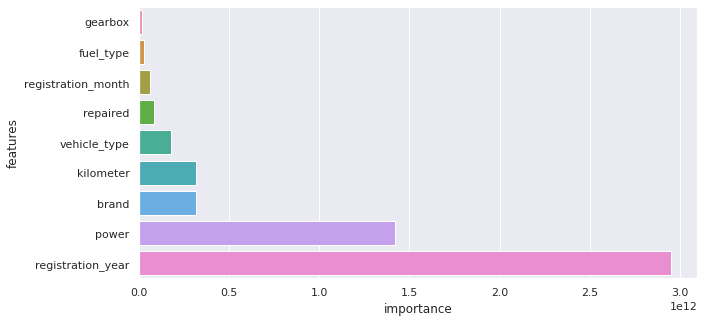

In [155]:
# Посмотрим на графике, какие показатели наиболее значимы

sns.set (rc={"figure.figsize":( 10 , 5 )})

sns.set_context("talk")
sns.set_style('darkgrid')
sns.set_palette("PRGn_r")
sns.set_context("notebook")

fi = pd.DataFrame()
fi['features'] = X_train.columns.values.tolist()
fi['importance'] = model_lgbm.booster_.feature_importance(importance_type='gain')

sns.barplot(x='importance', y='features', data=fi.sort_values(by='importance', ascending=True));


#### Модель 7: Градиентный бустинг LGBMRegressor с параметрами

In [156]:
model_lgbm_grid = LGBMRegressor(
    random_state=RANDOM_STATE, metric='rmse', force_row_wise=True, verbosity=0
)

In [157]:
param_lgbm_grid = [
    # словарь для модели LGBMRegressor()
    {
    
        'learning_rate': [0.1, 0.3],
        'n_estimators': [1000, 1550]
    }
]

In [158]:
%%time
start = time.time()

grid = RandomizedSearchCV(
    model_lgbm_grid, 
    param_lgbm_grid, 
    cv=5,
    scoring = 'neg_root_mean_squared_error', 
    random_state=RANDOM_STATE, 
    error_score='raise',
    n_jobs=-1,
    verbose=0
)

grid.fit(X_train, y_train) 

end = time.time()
learning_time_grid=end-start

start = time.time()

grid_pred = grid.best_estimator_.predict(X_valid)

end = time.time()
pred_time_grid=end-start

rmse_grid = root_mean_squared_error(y_valid, grid_pred)
print(f'Лучшая модель и ее параметры: \n\n', grid.best_params_, '\n')
print(f'Метрика лучшей модели при кросс-валидации: ', round(-grid.best_score_, 4),'\n')
print(f'Метрика на тестовой выборке: {rmse_grid:.4f}', '\n')
print(f'Время обучения с RandomizedSearchCV = {learning_time_grid:.4f}', '\n')
print(f'Время предсказания с RandomizedSearchCV = {pred_time_grid:.4f}', '\n')

Лучшая модель и ее параметры: 

 {'n_estimators': 1550, 'learning_rate': 0.1} 

Метрика лучшей модели при кросс-валидации:  1536.0104 

Метрика на тестовой выборке: 1542.2520 

Время обучения с RandomizedSearchCV = 3770.3700 

Время предсказания с RandomizedSearchCV = 5.9264 

CPU times: user 1h 2min 1s, sys: 21.1 s, total: 1h 2min 22s
Wall time: 1h 2min 56s


**Если не хочется ждать пока она досчитает**

Лучшая модель и ее параметры: 

 {'n_estimators': 1550, 'learning_rate': 0.1} 

Метрика лучшей модели при кросс-валидации:  1536.0104
Метрика на тестовой выборке: 1536.8074 

Время обучения с RandomizedSearchCV = 1447.7030
Время предсказания с RandomizedSearchCV = 5.8253
CPU times: user 23min 43s, sys: 6.73 s, total: 23min 50s
Wall time: 24min 13s

## Анализ моделей

In [159]:
# Соберем итоги

model_comparison = pd.DataFrame({'model': ['LinearRegressor', 'DescisionTreeRegressor', 'RandomForestRegressor',
                                           'CatBoostRegressor', 'CatBoostRegressor (param)', 'LGBMRegressor', 
                                           'LGBMRegressor (param)'],
                                 'rmse': [rmse_lr, rmse_dt, rmse_rscv, rmse_cat, rmse_model_cat, rmse_model_lgbm, rmse_grid],
                                 'learning_time': [learning_time_lr, learning_time_dt, learning_time_rscv,
                                                   learning_time_cat, learning_time_model_cat, learning_time_model_lgbm,
                                                  learning_time_grid],
                                 'predictions_time': [pred_time_lr, pred_time_dt, pred_time_rscv, pred_time_cat,
                                                      pred_time_model_cat, pred_time_model_lgbm, pred_time_grid]
                                
                                })
model_comparison.sort_values(by = 'rmse')

,model,rmse,learning_time,predictions_time
6,LGBMRegressor (param),1542.252,3770.370,5.926
3,CatBoostRegressor,1595.886,27.437,0.179
5,LGBMRegressor,1616.527,67.925,5.233
4,CatBoostRegressor (param),1695.113,89.205,0.082
1,DescisionTreeRegressor,2130.024,1.297,0.077
2,RandomForestRegressor,2130.024,181.410,0.207
0,LinearRegressor,2751.364,0.517,0.190


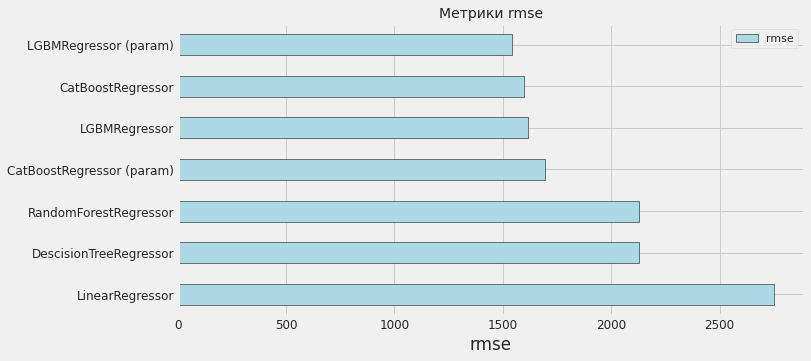

In [160]:
# Визуализация
plt.style.use('fivethirtyeight');

model_comparison.sort_values('rmse', ascending=False).plot(
    x='model', y='rmse', kind='barh', color='LightBlue', edgecolor='black');

# Как убрать это сообщение вверху графика - не знаю, точки с запятой наставила везде, оно все равно появляется

plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('rmse'); plt.xticks(size = 12);
plt.title('Метрики rmse', size = 14);

In [161]:
# Проверка модели CatBoostRegressor на тестовых данных

start = time.time()
pipe_cat_test_pred = pipe_cat.predict(X_test)
end = time.time()
pred_time_pipe_cat_test=end-start

rmse_pipe_cat = mean_squared_error(y_test, pipe_cat_test_pred, squared=False)
print(f'Метрика RMSE CatBoostRegressor = {rmse_pipe_cat:.4f}', '\n')
print(f'Время предсказания CatBoostRegressor = {pred_time_pipe_cat_test:.4f}')

Метрика RMSE CatBoostRegressor = 1589.1395 

Время предсказания CatBoostRegressor = 0.1937


**Дублирую,на всякий случай**

Метрика RMSE CatBoostRegressor = 1589.1395 

Время предсказания CatBoostRegressor = 0.1937

## Общий вывод

По точности предсказаний лидирует LGBMRegressor. Однако, у него самое долгое время обучения и предсказания.

На втором месте по точности (с незначительной разницей) CatBoostRegressor, при этом время обучения и предсказания у него значительно ниже, чем у LGBMRegressor. Из рассмотренных вариантов по времени - это 3-е место.

Наиболее быстрая по времени, но наименее подходящая по точности предсказания LinearRegressor.

Оптимальной моделью по группе параметров является CatBoostRegressor.